In [1]:
# Imports para uso geral
import os
import sys
import numpy as np
import scipy.fftpack as fft
import cv2
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy import signal, linalg
from copy import deepcopy

# Testes com Simulação Multicanal

## Modelagem SIMO

Para um determinado modelo, considera-se que o sinal trafega sobre diferentes canais. Cada canal tem determinado nível de ruído associado e 

\begin{equation}
    y_i = (x * h_i) + n_i
\end{equation}

É importante perceber que, para o caso bidimensional, não só os polos não podem ser compartilhados pelos canais como eles devem ser coprimos, ou seja, $\nexists \alpha \in \mathbb{R} \ | \ H_i(z) = \alpha H_j(z) \ \forall \ i \neq j$. Em que $H_i(z) = Z\{h_i[k]\}(z) = \sum_{k=-\infty}^{\infty}h_i[k] z^{-k}$. Normalmente, o fato dos canais já serem fracamente coprimos implica a não divisão de polos entre eles.

In [2]:
#---------------------------------------
# Módulo de funções de pré-processamento
#---------------------------------------

def img_norm (mat):
    '''Função de normalização de imagem após processamento.'''

    # Determinação de máximos e mínimos
    mmax = np.max(mat)
    mmin = np.min(mat)
    
    # Cálculo de matriz normalizada
    ret = ((mat - mmin) / (mmax - mmin)) * 255
    return ret.astype(np.uint8)

# Função de cálculo de matriz de convolução 2D
def convmatx2 (ker, size):
    '''Funç~ao de determinaç~ao de matriz de convoluç~ao
       para sinais bidimensionais usada para decomposiç~ao
       via matriz de Toeplitz. Referencia usada:
       https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.convolution_matrix.html
       
       Relaç~ao de inputs:
        1 - ker: Kernel a ser "vetorizado" para a matriz de conv.;
        2 - size: Tupla com tamanho da matriz de sa'ida. Percebe-se que 
            a relaç~ao de tamanhos 'e dada por: 
                  size[0] = s_ker[0] + s_x[0] - 1
                  size[1] = s_ker[1] + s_x[1] - 1'''

    vec_ker = ker.ravel()
    ret = linalg.convolution_matrix(vec_ker, size)
    return ret

# Função de estimação de PSNR
def calc_psnr (ref_img, lat_img):
    '''Função de estimação de PSNR de uma determinada imagem latente
       
       Relação de inputs:
        1 - ref_img: Imagem de referência
        2 - lat_img: Imagem latente para estimação da grandeza'''
    
    # Confere se as dimensões das imagens são adequadas e as normalizam
    if ref_img.shape != lat_img.shape:
        raise Exception("Imagens de dimensões diferentes, averiguar ocorrido.")
    
    MSE = np.mean((ref_img - lat_img)**2)
    MAX = np.max(ref_img)
    if MSE == 0:
        return 100
    
    PSNR = 20 * np.log10(MAX / np.sqrt(MSE))
    return PSNR

# Função de amostragem de floats diferentes entre si
def sample_floats (lo, hi, k=1):
    '''Função de escolha de números de ponto flutuante
       diferentes. Essa função será utilizada para a 
       determinação do desvio padrão dos canais gaussianos.
       
       Relação de inputs:
        1 - lo: Limite inferior
        2 - hi: Limite superior
        3 - k: Número de amostras'''
    
    ret  = np.zeros(k)
    seen = set()
    for ii in range(k):
        x = np.random.uniform(lo, hi)
        while x in seen:
            x = np.random.uniform(lo, hi)
        
        seen.add(x)
        ret[ii] = x
    
    return ret

# Função de determinação de kernel gaussiano
def gen_gaussian_kernel (size, sigma, param=3):
    '''Função de criação de kerneis gaussianos de determinado
       tamanho e variância
       
       Relação de inputs:
        1 - size: Dimensão de kernel (quadrado - ímpar)
        2 - sigma: Desvio padrão do kernel'''
    
    # Verifica se o tamanho em questão é ímpar
    if size % 2 == 0:
        size += 1
    
    # Criação de fase aleatória para o sistema
    if param != 0:
        ph_x, ph_y = np.random.choice(
            np.arange(-param, param), size=2
        )
    else:
        ph_x, ph_y = 0, 0
    
    # Definição offsets e índices geradores
    x0 = (size / 2) - 1 + ph_x
    y0 = (size / 2) - 1 + ph_y
    x  = np.arange(size)
    
    # Cálculo de gaussiana unidimensional e matriz
    gx  = np.exp(-(x - x0)**2 / (2 * sigma)**2)
    gy  = np.exp(-(x - y0)**2 / (2 * sigma)**2)
    G   = np.outer(gx, gy)
    G  /= np.sum(G.sum())
    return G[:(size - 1), :(size - 1)]

# Função para zeropad de imagens
def zero_pad (img, ker_size):
    '''Função de normalização de matrizes com diferentes tamanhos
       para evitar convolução circular e efeitos de espelhamento
       nas bordas.
       Relação de inputs:
        1 - img: Matriz contendo a imagem originial;
        2 - fft_sz: Próximo tamanho de janelamento eficiente.'''
    
    # Estimação de comprimento adequado
    im_x, im_y = img.shape
    s_fx       = fft.next_fast_len(ker_size[0] + im_x - 1)
    s_fy       = fft.next_fast_len(ker_size[1] + im_y - 1)
    
    # Criação da matriz de zeros e encaixe da imagem
    Mat               = np.zeros((s_fx, s_fy))
    Mat[:im_x, :im_y] = im
    return Mat

# Função de acréscimo de ruído branco 
def awgn (img, snr=20):
    '''Função de inserção de ruído AWGN em imagem de
       referência a partir de um determinado nível de
       relação sinal ruído (em dB).
       Relação de inputs:
        1 - img: Imagem de referência
        2 - snr: Valor da relação sinal ruído [dB]'''

    # Determinação da potência total da imagem
    pot_img = np.sum(img ** 2) / (img.shape[0] * img.shape[1])

    # Determinação da potência de ruído [dB]
    snr_cst   = np.power(10, snr / 10)
    pot_noise = pot_img / snr_cst

    # Criação do ruído branco e soma com a imagem de interesse
    noise = np.sqrt(pot_noise / 2) * np.random.standard_normal(
        img.shape
    )
    n_img = img + noise
    return n_img

## Construção dos Canais e Kerneis

Para a construção dos kerneis coprimos, foram calculados canais gaussianos com diferentes parâmetros $\sigma_i$, $\mu_i^x$ e $\mu_i^y$, para garantir a falta de redundância. Dessa forma, sabendo que os índices $i, j \in \{1, 2, \dots, s\}$ calculam-se as componentes $K_{ij}^k$ do $k$-ésimo kernel:

\begin{align}
    K_{ij}^k &= g_x^k \otimes g_y^k \\
    g_x^k &= \frac{1}{\sqrt{2 \pi \sigma_x^2}} \exp \Bigg( \frac{(i - \mu_x^k)^2}{2 \sigma_x^2} \Bigg) \\
    g_y^k &= \frac{1}{\sqrt{2 \pi \sigma_y^2}} \exp \Bigg( \frac{(j - \mu_y^k)^2}{2 \sigma_y^2} \Bigg) \\
\end{align}

Em que o parâmtro $s$ é a dimensão do kernel, que deve ser quadrado e a operação "$\otimes$" é o produto externo entre dois vetores. A estimação do kernel é feita na função `gen_gaussian_kernel` implementada na célula acima.

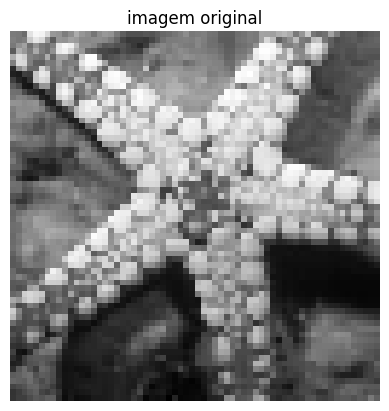

---------------------------


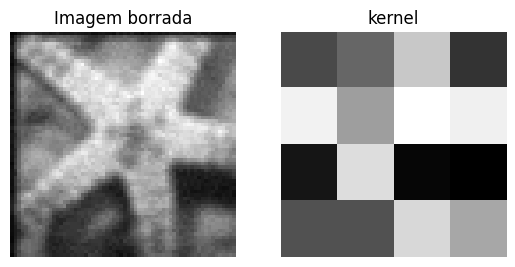

(137, 137)
(137, 137, 2)
(137, 137)
---------------------------


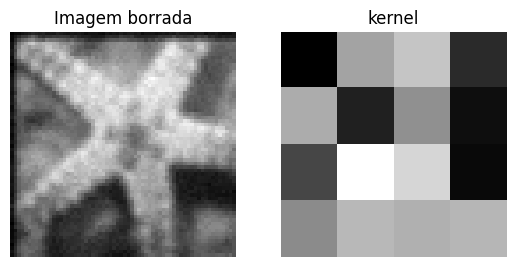

(137, 137)
(137, 137, 2)
(137, 137)
---------------------------


In [15]:
#---------------------------------------------------
# Módulo de borramento de imagem e criação de canais
#---------------------------------------------------

# Inicializa seed para RNG
np.random.seed()

# Leitura da imgem original
im_s = (64, 64)
im   = cv2.imread('starfish.jpeg', cv2.IMREAD_GRAYSCALE)
im   = cv2.resize(im, im_s)
s_fx = fft.next_fast_len(im.shape[0])
s_fy = fft.next_fast_len(im.shape[1])
#im   = cv2.resize(im, (s_fx, s_fy))

# Criação dos n canais gaussianos de forma iterativa
radiusPSF = 10
size_k    = 4 #2 * radiusPSF + 1
n         = 2 #5
lo, hi    = (1, size_k / 2) #radiusPSF)

# zero padding imagem e borrão
s_x       = 2 * s_fx + 2 * size_k + 1 #s_fx + 2 * radiusPSF + 1
s_y       = 2 * s_fx + 2 * size_k + 1 #s_fy + 2 * radiusPSF + 1
ker       = np.zeros((s_x, s_y, n))
sig_vec   = sample_floats(lo, hi, k=n)
blured_im = np.zeros((s_x, s_y, n))

# Aplicação dos diferentes kerneis na imagem de referência
X_tmp = fft.fft2(im, (s_x, s_y))
im    = fft.ifft2(X_tmp).real
#for ii, sig in enumerate(sig_vec):
#    k_tmp               = np.random.rand(size_k, size_k) #gen_gaussian_kernel(size_k, sig, size_k)
#    k_tmp              /= k_tmp.sum().sum()              # TESTE    
#    K_tmp               = fft.fft2(k_tmp, (s_x, s_y))    #fft.fft2(ker[:, :, ii], (s_x, s_y))
#    ker[:, :, ii]       = fft.ifft2(K_tmp).real
#    BIMG_tmp            = K_tmp * X_tmp
#    #blured_im[:, :, ii] = fft.ifft2(BIMG_tmp).real
#
#    # acrescenta ruído
#    tmp                 = fft.ifft2(BIMG_tmp).real
#    blured_im[:, :, ii] = awgn(tmp, snr=30)

ker[:size_k, :size_k, 0] = np.array([
    [0.28137002, 0.3885972 , 0.75671795, 0.20035163],
    [0.91013721, 0.59792427, 0.9617708 , 0.90449515],
    [0.08687498, 0.83484564, 0.03296456, 0.00838778],
   [0.31106622, 0.31390819, 0.81356953, 0.63244295]
])
#ker[:size_k, :size_k, 0]  = np.array([
#    [0., 0., 0., 0.],
#    [0., 1., 1., 0.],
#    [0., 1., 1., 0.],
#    [0., 0., 0., 0.]
#])
ker[:, :, 0] /= ker[:, :, 0].sum().sum()
ker[:size_k, :size_k, 1]  = np.array([
    [0.00432619, 0.56073908, 0.67914993, 0.14950353],
    [0.59215767, 0.11979369, 0.49662964, 0.05516508],
    [0.24583893, 0.87801624, 0.73582039, 0.03805045],
    [0.48026675, 0.63361043, 0.60828755, 0.62653676]
])
#ker[:size_k, :size_k, 1]  = np.array([
#    [1., 1., 1., 1.],
#    [1., 0., 0., 1.],
#    [1., 0., 0., 1.],
#    [1., 1., 1., 1.]
#])
ker[:, :, 1]      /= ker[:, :, 1].sum().sum()

K_tmp              = fft.fft2(ker[:, :, 0], (s_x, s_y))
BIMG_tmp           = K_tmp * X_tmp
tmp                = fft.ifft2(BIMG_tmp).real
blured_im[:, :, 0] = awgn(tmp, snr=20) # tmp
K_tmp              = fft.fft2(ker[:, :, 1], (s_x, s_y))
BIMG_tmp           = K_tmp * X_tmp
tmp                = fft.ifft2(BIMG_tmp).real
blured_im[:, :, 1] = awgn(tmp, snr=20) #tmp


#---------------------------------------------------------
# Impressão das imagens obtidas em comparação com original
#---------------------------------------------------------

plt.imshow(im[:s_fx, :s_fy], cmap='gray')
plt.title("imagem original")
plt.axis("off")
plt.show()
print("---------------------------")

for ii in range(n):
    # Impressão dos resultados preliminares iniciais
    plt.subplot(1, 2, 1)
    plt.imshow(blured_im[:s_fx, :s_fy, ii], cmap='gray')
    plt.title("Imagem borrada")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(ker[:size_k, :size_k, ii], cmap='gray')
    plt.title("kernel")
    plt.axis("off")
    plt.show()
    print(im.shape)
    print(blured_im.shape)
    print(ker[:,:,0].shape)
    print("---------------------------")

## Descrição do modelo

Para estimar a deconvolução do sinal por meio da análise de multicanal, primeiramente, percebe-se que, para cada dois pares de sinais e canais adjacentes, observa-se que, para uma modelagem sem ruído:

\begin{align}
    h_i * y_j - h_j * y_i &= h_i * (h_j * x) - h_j * (h_i * x) \\
    &= h_j * (h_i * x) - h_j * (h_i * x) \\
    &= 0
\end{align}

Para evitar o custo computacional da operação de convolução, perebe-se que é possível utilizar a trasnformada rápida de Fourier $\mathcal{F}\big\{y(x, y)\big\}(u, v) = Y(u, v)$ para que então seja possível, no domínio da frequência, pensar em um problema equivalente apenas com o produto termo à termo de duas matrizes. 

Queremos estimar a imagem latente $\hat{x}$ e os diferentes kerneis $\hat{h_i}$ que minimizam o erro quadrátio médio de ambas as relações apresentadas (deifnição ed $y_i$ e relação acima). Pode-se modelar o problema como a seguinte minimização no domínio das frequências:

\begin{align}
    \mathcal{L}(\hat{X}, \hat{K_i}, Y, \vec{\lambda}) &= || Y_i - \hat{X} \hat{K_i} ||_2^2 + \sum_{j \neq i} \lambda_1 || \hat{K_i} Y_{j} - \hat{K_j} Y_i ||_2^2 + \lambda_2 ||\hat{K_i}||_2^2\\ \\
    \hat{X} &= \mathcal{F}\{\hat{x}\}(u, v) \\
    \hat{Y_i} &= \mathcal{F}\{\hat{y_i}\}(u, v) \\
    \hat{K_i} &= \mathcal{F}\{\hat{k_i}\}(u, v)
\end{align}

No dominio dos pixels, pode-se montar o Lagrangeano da seguinte forma:

\begin{equation}
    \mathcal{L}(\hat{x}, \hat{k_i}, y, \vec{\lambda}) = || \hat{x} * \hat{k_i} - y_i ||_2^2 + \sum_{j \neq i} \lambda_1 || \hat{k_i} * y_j - \hat{k_j} * y_i ||_2^2 + \lambda_2 ||\hat{k_i}||_2^2
\end{equation}

Percebe-se ainda que outras funções de penalização e restrição devem ser acrescentadas para garantir algumas propriedades importantes nas imagens latentes obtidas. Um exemplo é a norma `fused_lasso` usada para garantir a concentração de componentes dos kerneis $h_i$, mas por hora estes aspectos ainda não estão sendo considerados. Por se tratar de um problema de mínimos quadrados, para a descida de gradiente usada utilizou-se a expressão:

\begin{align}
    \nabla || g(X) ||_2^2 &= 2 J_g^T g(X) \\
    \nabla^2 || g(X) ||_2^2 &= 2 J_g^T J_g + \sum_{i} g_i(X) \nabla^2 g_i(X)
\end{align}

In [17]:
#-----------------------------------------------
# Funções de calculo de fç de custo e jacobiano
#-----------------------------------------------

def sec_au (func, Y, K_vec, X, d, lbda=0.1, iter_max=1000):
    '''Função de busca inexata de tamanho de passo por meio do
       método da seção áurea, nele computa-se um tamanho de passo
       satisfatório para a descida de gradiente a partir da assunção
       da monotonicidade da função, visto a convexidade do problema.
       Relação de inputs:
        1 - func: Objeto funcional para avaliação da fç de custo;
        2 - x0: Ponto inicial da busca;
        3 - d: Direação da realização da busca (-grad).'''

    # Declaração de parâmetros importantes para a execução do algoritmo
    theta_1 = (3 - np.sqrt(5)) / 2
    theta_2 = 1 - theta_1
    eps     = 1e-10
    rho     = 1
    b_max   = 1e8
    D       = fft.fft2(d)

    # Determinação do intervalo de interesse para observação da fç: [a, b]
    a     = 0
    s     = rho
    b     = 2 * rho
    phi_b = func(Y, K_vec + b * D,  X=X, lbda1=lbda)
    phi_s = func(Y, K_vec + s * D,  X=X, lbda1=lbda)
    ii    = 0
    while phi_b < phi_s and 2 * b < b_max and ii < iter_max:
        a     = s
        s     = b
        b     = 2*b
        phi_s = phi_b
        phi_b = func(Y, K_vec + b * D, X, lbda)
        #ii   += 1

    # Determinação do comprimento do passo em si a paritir de [a, b]
    u     = a + theta_1 * (b - a)
    v     = a + theta_2 * (b - a)
    phi_u = func(Y, K_vec + u * D,  X=X, lbda1=lbda)
    phi_v = func(Y, K_vec + v * D,  X=X, lbda1=lbda)
    ii    = 0
    while b - a > eps and ii < iter_max:
        #ii += 1
        if phi_u < phi_v:
            b     = v
            v     = u
            u     = a + theta_1 * (b - a)
            phi_v = phi_u
            phi_u = func(Y, K_vec + u * D, X=X, lbda1=lbda)
        else:
            a     = u
            u     = v
            v     = a + theta_2 * (b - a)
            phi_u = phi_v
            phi_v = func(Y, K_vec + v * D, X=X, lbda1=lbda)

    # Cálculo do passo como ponto médio do intervalo [u, v]
    return (u + v) / 2

def sec_au_mod (func, Y, K_vec, X, d, lbda=0.1, num=5):
    '''Função de avaliação de melhor passo dentro do 
       intervalo (0, 1) quantizado pelo número num.
       Relação de inputs:
        1 - func: Objeto funcional para avaliação da fç de custo;
        2 - x0: Ponto inicial da busca;
        3 - d: Direação da realização da busca (-grad).'''
    
    # Determinação do intervalo
    grid = np.linspace(0.05, 1.0, num)

    # Normalização da direção
    _, _, n = Y.shape
    n_jac   = 0
    for ii in range(n):
        n_jac += linalg.norm(d[:, :, ii]) ** 2

    # Descobre a fft da direção
    if n_jac > 1e3:
        D      = fft.fft2(d / np.sqrt(n_jac))
    else:
        D      = fft.fft2(d)

    # Adquire valores em cada passo da fç
    vals = [func(Y, K_vec + vv * D,  X=X, lbda1=lbda) / n_jac for vv in grid]

    # Retorna valores mínimos alcaçados
    return np.min(vals)

def cost_fun (Y, K_vec, X=None, lbda1=0.1):
    '''Função de custo utilizada para a descida de gradiente.
       ela recebe reproduz o lagrangeano a partir da equaçao
       disposta no modelo
       Relação de inputs: 1 - Y: Estrutura contendo as imagens captadas;
        2 - K_vec: Estrutura contendo os Kerneis estimados;
        3 - X: Imagem de referência para minimização do erro no dom. da freq.;'''

    # Declaração das variáveis utilizadas
    _, _, n = Y.shape
    lag     = 0
    tmp     = np.zeros_like(Y[:, :, 0])

    # Iteraç~ao por cada componente
    for ii in range(n):
        KK = K_vec[:, :, ii]
        YY = Y[:, :, ii]

        # Computação da fç de custo
        if not isinstance(X, type(None)):
            tmp += reg_vals(X * KK - YY)
            lag += lbda1 * linalg.norm(fft.ifft2(tmp).real) ** 2

        # Laço para computação dos termos de multicanal
        for jj in range(n):            # for jj in range(ii, n):
            if jj == ii: continue
            c_tmp = fft.ifft2(
                Y[:, :, jj] * KK - YY * K_vec[:, :, jj]
            ).real
            lag  += linalg.norm(reg_vals(c_tmp)) ** 2

    return lag

def cost_fun_jac (Y, K_vec, X=None, lbda1=0.1):
    '''Funçao de custo utilizada para a descida de gradiente.
       ela recebe reproduz o lagrangeano a partir da equaçao
       disposta no modelo
       Relação de inputs: 
        1 - Y: Estrutura contendo as imagens captadas;
        2 - K_vec: Estrutura contendo os Kerneis estimados;
        3 - X: Imagem de referência para minimização do erro no dom. da freq.;'''

    # Declaração das variáveis utilizadas
    sx, sy, n = Y.shape

    # Constroi cada partícula por canal
    err = np.zeros_like(K_vec.shape)         # Depois pensar nesse sjt...
    jac = np.zeros(K_vec.shape)

    # Cálculo do erro entre kerneis
    for ii in range(n):       # for ii in range(1, n):
        KK  = K_vec[:, :, ii] # ii - 1
        YY  = Y[:, :, ii]     # ii - 1
        
        # Verifica se há termo de erro de reconstrução
        if not isinstance(X, type(None)):
            # Calcula termo do erro de reconstrução
            err              = reg_vals(X * KK - YY)
            jac[:, :, ii-1] += 2 * lbda1 * fft.ifft2(
                np.conj(KK) * err
            ).real
        
        # Calcula erro e componentes do jacobiano
        for jj in range(n):  # for jj in range(ii, n)
            if ii == jj:
                continue

            tmp = (Y[:, :, jj] * KK) - (YY * K_vec[:, :, jj])
            
            # TESTE (SEÇÃO ABAIXO)
            if ii > 0:
                jac[:, :, ii-1] += fft.ifft2(
                    np.conj(Y[:, :, jj]) * tmp
                ).real
            
            jac[:, :, jj]   += fft.ifft2(
                np.conj(-YY) * tmp
            ).real

    return 2 * jac

#-------------------------------------
# Descida de gradiente pelo método BB
#-------------------------------------

def is_inv (mat):
    '''Função resposável pela verificação se a matriz "mat" é ou não
       inversível.
       Rlação de inputs:
        1 - mat: Matriz avaliada'''

    # Avaliação das condições de de inversibilidade
    mat  = reg_vals(mat)
    cond = np.linalg.cond(mat)
    ret  = True if cond < 1 / sys.float_info.epsilon else False
    return ret

def bb_des_k (Y, K_vec, X=None, sk=4, lbda=1e-3, mu_0=0.5, iter_max=1000, p_flag=False, eps=1e-5):
    '''Implementaç~ao do m'etodo quase-Newton de Barzilai-Borwein
       que aproxima a matrix hessiana para direç~ao de descida por meio
       da aproximação da direç~ao de Newton pela diferença sucessiva
       dos vetores gradiente em cada iteraç~ao do m'etodo.
       Relação de inputs:
        1 - Y: Estrutura contendo as imagens captadas;
        2 - K_vec: Estrutura contendo os Kerneis estimados;
        3 - X: Imagem de referência para minimização do erro no dom. da freq.;
        4 - idx: Índice do kernel sendo otimizado;
        5 - sigma: Parâmetro de atenuação dos gradientes;
        6 - mu: Parâmetro de suavização da convergência;
        7 - iter_max: Parâmetro de número máximo de iterações da descida;
        8 - p_flag: Parâmetro de indicação de impressão (p/ debug);
        9 - eps: Parâmetro de tolerância de gradiente.'''

    # Declaração de variáveis
    k_0         = fft.ifft2(K_vec).real
    K_ret       = K_vec
    jac_0       = np.zeros(k_0.shape)
    jac_1       = np.zeros(k_0.shape)
    ii          = 0
    s_x, s_y, n = Y.shape

    # Iteração inicial da descida de gradiente
    jac_0     = cost_fun_jac(Y, K_vec, X=X, lbda1=lbda)
    jac_0     = reg_vals(jac_0)
    jac_v     = np.zeros(iter_max)
    lag_v     = np.zeros(iter_max)
    err_vec   = np.zeros((n, iter_max))
    jac_v[0]  = linalg.norm(jac_0.ravel())
    n_jac     = linalg.norm(jac_0)
    if n_jac > 1e3:
        jac_0 /= n_jac

    # Atualiza o kernel com a variação do grad
    k_1                      = k_0 - mu_0 * jac_0
    k_1[sk:, sk:, :] = 0.0
    k_1[:sk, sk:, :] = 0.0
    k_1[sk:, :sk, :] = 0.0
    K_ret                    = fft.fft2(k_1)

    # Inicialização de variáveis de estatística de debug
    a1_c = 0
    a2_c = 0
    mu_c = 0

    # Início da iteração do algoritmo principal
    while ii < iter_max and n_jac > eps:
        # Computa gradiente da K-ésima iteração
        print(f"\r{ii + 1}/{iter_max}", end="")
        jac_1 = cost_fun_jac(
            Y,
            K_ret,
            X=X,
            lbda1=lbda
        )
        
        # Regulariza a matriz jacobiana
        for jj in range(n):
            n_jac      = linalg.norm(reg_vals(jac_1[:, :, jj]))
            jac_v[ii] += n_jac ** 2
        
        jac_v[ii] = np.sqrt(jac_v[ii])
        lag_v[ii] = cost_fun(Y, fft.fft2(k_1), X=X, lbda1=lbda)

        # Computa diferenças entre passo passado e gradiente passado
        ss    = k_1.ravel()   - k_0.ravel()
        yy    = jac_1.ravel() - jac_0.ravel()
        tmp1  = np.dot(yy, yy)
        tmp2  = np.dot(ss, yy)

        # Avaliação das condições de inversibilidade de tmp1 e tmp2
        if tmp1 >= 1e-8:
            # Calcula o passo a_1
            mu    = tmp2 / tmp1
            a1_c += 1

        elif tmp2 >= 1e-8:
            # Calcula passo a_2 em caso de excessão
            mu    = np.dot(ss, ss) / tmp2
            a2_c += 1

        else:
            # Em caso de ambos os passos n estarem definidos, steepest descent
            mu    = mu_0
            mu_c += 1

        # Atualiza as variáveis e aplica o passo calculado
        for jj in range(n):
            k_0[:, :, jj]             = fft.ifft2(K_ret[:, :, jj]).real
            k_1[:, :, jj]             = k_0[:, :, jj] - mu * jac_1[:, :, jj]
            k_1[sk:, sk:, jj]         = 0.
            k_1[:sk, sk:, jj]         = 0.
            k_1[sk:, :sk, jj]         = 0.
            jac_0[:, :, jj]           = jac_1[:, :, jj]
            K_ret[:, :, jj]           = fft.fft2(k_1[:, :, jj])

            # Atualiza vetor de erros.
            err_vec[jj, ii] = linalg.norm(
                (k_1[:sk, :sk, jj] / np.sum(k_1[:sk, :sk, jj])) - 
                (ker[:sk, :sk, jj] / np.sum(ker[:sk, :sk, jj]))
            )

        # Incrementa contador de iterações
        ii += 1

    # Impressão de estatísticas de debug
    if p_flag is True:
        print()
        print("ESTATÍSTICAS PARA DEBUG:")
        print(f"pct a_1: {np.round(100 * a1_c / (ii + 1))}%")
        print(f"pct a_2: {np.round(100 * a2_c / (ii + 1))}%")
        print(f"pct mu:  {np.round(100 * mu_c / (ii + 1))}%")
        print(f"passo:   {mu}")
        t = np.arange(ii)
        plt.subplot(2, 1, 1)
        plt.plot(t, jac_v[:ii])
        plt.ylabel(r"$||\nabla \mathcal{L}||$")
        plt.subplot(2, 1, 2)
        plt.plot(t, lag_v[:ii])
        plt.ylabel(r"$\mathcal{L}$")
        plt.show()

    return K_ret, err_vec, lag_v

#----------------------------
# ALgoritmo de máxima descida
#----------------------------

def grad_des_k (Y, K_vec, X=None, sk=4, lbda=1e-3,
                mu=1e-3, iter_max=1000, p_flag=False, eps=0.0):
    '''Função de descida de gradiente baseada na descida de
       gradiente implementada pelo Kenji, utiliza as funções
       de custo FUSED LASSO e seu jacobiano para tanto.
       Relação de inputs:
        1 - Y: Estrutura contendo as imagens captadas;
        2 - K_vec: Estrutura contendo os Kerneis estimados;
        3 - X: Imagem de referência para minimização do erro no dom. da freq.;
        4 - idx: Índice do kernel sendo otimizado;
        5 - sigma: Parâmetro de atenuação dos gradientes;
        6 - mu: Parâmetro de suavização da convergência;
        7 - iter_max: Parâmetro de número máximo de iterações da descida;
        8 - p_flag: Parâmetro de indicação de impressão (p/ debug);
        9 - eps: Parâmetro de tolerância de gradiente.'''

    # Estimação das DFT's das imagens utilizadas
    ii          = 0
    n_jac       = 1                      # Inicializa a norma do jacobiano
    jac_v       = np.zeros((iter_max))   # Vetor para debug
    lag_v       = np.zeros((iter_max))   # Vetor para debug
    s_x, s_y, n = Y.shape                # Estimação do número de canais
    err_vec     = np.zeros((n, iter_max))
    K_ret       = deepcopy(K_vec)

    # Estimação do vetor a ser computado
    jac         = np.zeros(K_vec.shape)
    mu          = 0.5
    sec_au_flag = True

    # Iterações da descida de gradiente
    while ii < iter_max: # and n_jac > eps:
        print(f"\r{ii + 1}/{iter_max}", end="")
        # Calculo da matriz jacobiana da função de custo
        jac       = cost_fun_jac(Y, K_ret, X=X, lbda1=lbda)
        lag       = cost_fun(Y, K_ret, X=X, lbda1=lbda)
        lag_v[ii] = lag

        # Normalização do vetor Jacobiano, caso necessário
        #jac = reg_vals(jac)

        # Início de computaç~ao da descida em si
        n_jac = 0
        for jj in range(n):
            n_jac += linalg.norm(jac[:, :, jj]) ** 2
        
        # Normalização do gradiente
        if sec_au_flag is False:
            if n_jac > 1e-3:
                jac /= np.sqrt(n_jac)

        jac_v[ii] = np.sqrt(jac_v[ii])

        # Definição do tamanho do passo por meio do método da seção áurea
        if sec_au_flag is True:
            #mu    = sec_au(cost_fun, Y, K_ret, X, -1 * jac, lbda=lbda)
            mu    = sec_au_mod(cost_fun, Y, K_ret, X, -1 * jac, lbda=lbda)

        # Zera todos os termos fora do tamanho do filtro
        for jj in range(n):
            k                      = fft.ifft2(K_ret[:, :, jj]).real
            k                      = k - mu * jac[:, :, jj]         # TESTE OOOOOOOLHA
            k[sk:, sk:]    = 0.                             # TESTE
            k[:sk, sk:]    = 0.                             # TESTE
            k[sk:, :sk]    = 0.                             # TESTE
            #k                     /= k.sum().sum()                  # TESTE
            K_ret[:, :, jj]        = fft.fft2(k)                    # TESTE

            # Atualiza vetor de erros.
            #err_vec[jj, ii] = linalg.norm(
            #    (k[:sk, :sk]       / np.sum(k[:sk, :sk])) - 
            #    (ker[:sk, :sk, jj] / np.sum(ker[:sk, :sk, jj]))
            #)

        # Incrementa contador de iterações
        ii += 1
    
    # Ciclo de debug
    if p_flag is True:
        #t = np.arange(ii)
        #plt.subplot(2, 1, 1)
        #plt.plot(t, jac_v[:ii])
        #plt.ylabel(r"$||\nabla \mathcal{L}||$")
        #plt.subplot(2, 1, 2)
        #plt.plot(t, lag_v[:ii])
        #plt.ylabel(r"$||\mathcal{L}||$")
        #plt.xlabel("Iterações")
        #plt.show()
        for ii in range(n):
            k = fft.ifft2(K_ret[:, :, ii]).real
            plt.imshow(k[:sk, :sk])
            plt.title(f"Estimativa de K_{ii+1}")
            plt.axis("off")
            plt.show()
    
    return K_ret, err_vec, lag_v

def fixed_point_x (X, K_vec, Y, lbda=1e-3, mu=1e-3, iter_max=1000, 
                p_flag=False):
    '''Função de minimização da imagem latente x_hat a partir dos novos
       kerneis estimados. Para esta modelagem ustiliza-se do algoritmo 
       RED para sua implementação em ponto fixo, dessa forma, minimiza-se
               L(X, K, Y) + x^T(x - f(x)) -> f(): denoiser
       Relação de inputs:
        1 - x: Imagem latente inicial;
        2 - k: Tensor de kerneis (domínio dos pixels);
        3 - Y: Tensor de DFTs das imagens distorcidas
        4 - size_im: Tupla com dimensões da imagem no domínio dos pixels;
        5 - mu: mu: Parâmetro de suavização da convergência;
        6 - iter_max: Parâmetro de número máximo de iterações da descida;
        7 - eps: eps: Parâmetro de tolerância de gradiente.'''

    # Determinação do denoiser utilizado (non-local means da lib cv2)
    denoiser = cv2.fastNlMeansDenoising

    # Inicializa variáveis necessárias no Domínio do tempo
    x0        = fft.ifft2(X).real
    sx, sy, n = Y.shape
    
    # Inicia variável de avaliação da fç de custo
    lag_v     = np.zeros(iter_max)

    # Itera sobre o problema abordando-o pelo método de ponto fixo
    for ii in range(iter_max):
        print(f"\r{ii + 1}/{iter_max}", end="")

        # Calcula termo de ruído
        deno   = denoiser(x0.astype(np.uint8))

        # Soma na razão termo com denoiser
        frac   = lbda * fft.fft2(deno)

        # Soma termo constante ao denominador
        tmp1   = (lbda * np.ones((sx, sy))).astype(np.complex128)
        tmp2   = np.zeros_like(tmp1)

        # Itera por cada um dos canais observados
        for jj in range(n):
            # Soma termos relativos à canais e constantes de reg.
            tmp1 += mu * np.conj(K_vec[:, :, jj]) * K_vec[:, :, jj]
            tmp2 += mu * np.conj(K_vec[:, :, jj]) * Y[:, :, jj]

        # Divide pelo denominador encontrado
        frac  += tmp2
        frac  /= tmp1

        # Atualiza valores estimados para cada iteração
        x      = fft.ifft2(frac).real
        n_term = lbda * (x - deno)
        x0     = x

        # Calcula Lagrangeano
        lag_v[ii]  = cost_fun(Y, K_vec, fft.fft2(x), lbda1=mu) 
        lag_v[ii] += linalg.norm(x.T @ n_term)

    # Realiza plotagem para fins de debug
    if p_flag is True:
        plt.imshow(x[:s_fx, :s_fy])
        plt.title(r"Estimativa de $\hat{x}$")
        plt.axis("off")
        plt.show()
        plt.semilogy(lag_v)
        plt.title(r"$\mathcal{L}$")
        plt.show()

    return fft.fft2(x), n_term

def grad_des_x (X, K_vec, Y, lbda=1e-3, mu=1e-3, iter_max=1000, 
                p_flag=False):
    '''Função de minimização da imagem latente x_hat a partir dos novos
       kerneis estimados. Para esta modelagem ustiliza-se do algoritmo 
       RED para sua implementação de máxima descida, dessa forma, 
       minimiza-se:
               L(X, K, Y) + x^T(x - f(x)) -> f(): denoiser
       Relação de inputs:
        1 - x: Imagem latente inicial;
        2 - k: Tensor de kerneis (domínio dos pixels);
        3 - Y: Tensor de DFTs das imagens distorcidas
        4 - size_im: Tupla com dimensões da imagem no domínio dos pixels;
        5 - mu: mu: Parâmetro de suavização da convergência;
        6 - iter_max: Parâmetro de número máximo de iterações da descida;
        7 - eps: eps: Parâmetro de tolerância de gradiente.'''

    # Determinação do denoiser utilizado (non-local means da lib cv2)
    denoiser = cv2.fastNlMeansDenoising

    # Inicializa variáveis necessárias no Domínio do tempo
    x         = fft.ifft2(X).real
    sx, sy, n = Y.shape
    jac_v     = np.zeros(iter_max)
    lag_v     = np.zeros(iter_max)

    # Itera sobre o problema abordando-o pelo método de ponto fixo
    for ii in range(iter_max):
        print(f"\r{ii + 1}/{iter_max}", end="")

        # Inicializa nova estimativa de x
        grad  = np.zeros_like(x)
        
        # Itera por cada um dos canais observados
        for jj in range(n):
            # Recupera termos de interesse p/ reconstrução
            KK, YY = K_vec[:, :, jj], Y[:, :, jj]

            # Calcula termos de erro de reconstrução para cada kernel
            tmp = mu * fft.ifft2(
                np.conj(KK) * (KK * X - YY),
                x.shape
            ).real

            # Incrementa o gradiente com termo em questão
            grad += tmp

        # Atualiza valores estimados para cada iteração
        n_term = lbda * (x - denoiser(x.astype(np.uint8)))
        grad  += n_term

        # normaliza o gradiente
        grad      = reg_vals(grad)
        n_jac     = linalg.norm(grad)
        jac_v[ii] = n_jac 
        #grad     /= n_jac
        
        # Calcula lagrangeano da fç para fins de debug
        lag_v[ii]  = reg_vals(cost_fun(Y, K_vec, X, lbda1=lbda))
        lag_v[ii] += linalg.norm(reg_vals(x.T @ n_term))
        
        # Efetua passo de máxima descida
        x     = x - mu * grad
        X     = fft.fft2(x)

    # Realiza plotagem para fins de debug
    if p_flag is True:
        plt.imshow(x[:s_fx, :s_fy])
        plt.title(r"Estimativa de $\hat{x}$")
        plt.axis("off")
        plt.show()
        plt.plot(jac_v)
        plt.title(r"$\nabla_x \mathcal{L}$")
        plt.show()
        plt.plot(lag_v)
        plt.title(r"$\mathcal{L}$")
        plt.show()

    return fft.fft2(x), n_term

## Loop principal

Onde a mágica acontece a partir das matrizes:

    1. $ X $: `m` - Matriz contendo imagem de referência
    2. $ K_i $: `K_hat` - Estrutura contendo kerneis estimados
    3. $ Y $: `Y` - Estrutura contendo imagens percebidas por cada sensor

## TODOS:

* Sistematizar
* Fazer busca no espaço de parâmetros
* Buscar comparação com outros 
* Testar com ruído "salt & peper"

In [8]:
#-----------------------------------------------------
# Funções usadas em ambos os processos de minimização:
#-----------------------------------------------------

def reg_vals (Mat):
    '''Função de adequação de valores NaN e inf 
       em matrizes do tipo numpy.
       Relação de inputs:
        1 - Mat: Matriz com valores a serem regularizados.'''

    return np.nan_to_num(Mat, nan=0.0, posinf=1e10, neginf=-1e10)

#------------------------------------------------------------------
# Rotina de deconvolução em caso sem ruído através da otimização
# no domínio da frequência da equação:
#       min  ||Y_i - K_i^k X^k|| + lambda ||Y_j K_i^k - Y_i K_javaliado^k|| 
#------------------------------------------------------------------

def mult_decon_noiseless (y, n, K_hat=None, sk=4, eps=1e-4, iter_max=10_000, p_flag=True):
    '''Função de deconvolução de imagens usando as múltiplas
       saídas dos diversos canais gerados, seu resultado é uma 
       imagem latente obtida através da

       Relação de inputs:
        1 - y: Array multidimensional contendo imagens de todos os 
               canais
        2 - n: Números de canais disponíveis para o problema
        eps: Parâmetro de tolerância utilizado
        lamb: Parâmetro multiplicador da restrição de multicanal
        iter_max: Parâmetro com número máximo de iterações'''

    # calcula chute inicial para x_hat e salva as suas dimensões
    x_hat       = np.mean(y, axis=2) #+ 0.1 * im/linalg.norm(im))/2
    # ^ Observação de resultado... (hipótese: sensibilidade de ponto
    #   inicial). Ver se melhora com correção da convolução circular.
    x_hat      /= linalg.norm(x_hat)
    s_x, s_y, _ = y.shape
    k_hat       = np.zeros((s_x, s_y, n))
    
    # Inicializa variável de vetor de erro
    err_vec = np.zeros((n, iter_max))

    # Calcula as DFT's das grandezas envolvidas e inicializa o processo de otimização
    X_hat = fft.fft2(x_hat, (s_x, s_y))
    Y     = np.zeros((s_x, s_y, n), dtype=complex)
    for ii in range(n):
        Y[:, :, ii]     = fft.fft2(y[:, :, ii], (s_x, s_y))
    
    if isinstance(K_hat, type(None)):
        K_hat = np.zeros((s_x, s_y, n), dtype=complex)
        for ii in range(n):
            # TESTE
            ttmp            = gen_gaussian_kernel(sk, 1)
            ttmp2           = np.zeros_like(x_hat)
            ttmp2[:sk, :sk] = ttmp
            K_hat[:, :, ii] = fft.fft2(ttmp2)
            #K_hat[:, :, ii] = fft.fft2(np.ones_like(x_hat)) #np.divide(Y[:, :, ii], X_hat)

    # Cálculo da matriz de condição de parada inicial (basta ser > eps)
    cond = 10.0

    # Laço de descida de gradiente e otimização
    it = 0 
    while cond > eps and it < iter_max:
        # Otimização efetuada por cada componente de canal
        # Regulariza matrizes de entrada
        X_hat        = reg_vals(X_hat)
        tmp, err_vec, lag_v = bb_des_k(
            Y,
            K_hat,
            #X     = X_hat, #X_tmp,
            sk       = sk,
            lbda     = 1,
            mu_0     = 0,
            iter_max = 100_000,
            p_flag   = False
        )
        #tmp, err_vec, lag_v = grad_des_k(
        #    Y,
        #    K_hat,
        #    #X        = X_hat, #X_tmp,
        #    sk       = sk,
        #    lbda     = 1,
        #    iter_max = 100_000, #100_000,
        #    p_flag   = False
        #)

        for ii in range(n):
            K_hat[:, :, ii] = reg_vals(tmp[:, :, ii])

        # Impressão de variáveis de controle para cada iteração.
        if p_flag:
            print(f"Grandezas da {it + 1}a iteração")
            for idx in range(n):
                tmp_k = fft.ifft2(K_hat[:, :, idx]).real
                fftX  = np.divide(Y[:, :, idx], K_hat[:, :, idx] + 0.001)
                x_tmp = fft.ifft2(fftX).real
                
                fig, ((ax1, ax2), (ax4, ax3)) = plt.subplots(2, 2)
                ax1.imshow(ker[:sk, :sk, idx])
                ax1.axis("off")
                ax1.set_title(f"Kernel original {idx + 1}")
                ax2.imshow(tmp_k[:sk, :sk] / tmp_k.sum().sum())
                ax2.axis("off")
                ax2.set_title(f"Kernel estimado {idx + 1}")
                ax3.imshow(x_tmp[:s_fx, :s_fy])
                ax3.axis("off")
                ax3.set_title(f"Imagem estimada {idx + 1}")
                ax4.imshow(blured_im[:s_fx, :s_fy, idx])
                ax4.axis("off")
                ax4.set_title(f"Imagem borrada {idx + 1}")
                fig.colorbar(None, ax=[ax1, ax2, ax3, ax4])
                plt.show()
                
                plt.semilogy(lag_v)
                plt.ylabel("$\mathcal{L}$ semilog")
                plt.xlabel("Iteração")
                plt.show()

            #print(f"Canais de minimização bem sucedida:")
            #print(f"PSNR: {calc_psnr(im, x_tmp)}")
            #print(f"condição de minimização: {np.round(linalg.norm(cond), 3)}")
            #print("---------------------------")

        # Atualiza a condição
        cond = 0
        for ii in range(n):
            cond += linalg.norm(cost_fun_jac(Y, K_hat, lbda1=1))

        # Incrementa o índice de iteração
        it  += 1

    # Transporta a imagem latente e os Kerneis para o domínio dos pixels
    x_hat = np.zeros_like(x_hat)
    print(f"condição de minimização: {np.round(linalg.norm(cond), 3)}")
    for ii in range(n):
        fftX            = np.divide(Y[:, :, ii], K_hat[:, :, ii] + 0.001)
        x_hat          += fft.ifft2(fftX).real / n
        k_hat[:, :, ii] = fft.ifft2(K_hat[:, :, ii]).real

    return img_norm(x_hat), k_hat, err_vec, lag_v

# --------------------------------------------------------------
# Início dos testes com estimação de x e k no domínio dos pixels
# --------------------------------------------------------------

x_hat, k_hat, err, lag = mult_decon_noiseless(
    blured_im, 
    n,
    sk=size_k,
    iter_max=1, #100_000, 
    p_flag=False
)

# Imprime métricas medidas:
print(f"PSNR ESTIMADA IM. LATENTE: {calc_psnr(im, x_hat)} dB")

# Imprime a imagem latente estimada
plt.imshow(x_hat[:s_fx, :s_fy])
plt.axis("off")
plt.title("Imagem Latente estimada")
plt.show()

# Imprime kerneis originais e estimados:
map = cm.ScalarMappable(norm=None, cmap='gray')
print("---------------------------")
for ii in range(n):
    Y     = fft.fft2(blured_im[:, :, ii])
    K     = fft.fft2(k_hat[:, :, ii])
    tmp   = fft.ifft2(np.divide(Y, K + 0.001)).real
    tmp   = reg_vals(tmp)
    tmp  /= linalg.norm(tmp)
    error = linalg.norm(
        (ker[:size_k, :size_k, ii].ravel()   / np.sum(ker[:size_k, :size_k, ii])) - 
        (k_hat[:size_k, :size_k, ii].ravel() / np.sum(k_hat[:size_k, :size_k, ii]))
    )
    print(f"Erro final entre kerneis:  {error}")
    print(f"PSNR entre imgs_lat:       {np.round(calc_psnr(im / linalg.norm(im), tmp), 3)} dB")
    fig, ((ax1, ax2), (ax4, ax3)) = plt.subplots(2, 2)
    ax1.imshow(ker[:size_k, :size_k, ii], cmap='gray')
    ax1.axis("off")
    #ax1.set_title(f"Kernel original {ii + 1}")
    ax1.set_title(f"Kernel Original {ii + 1}")
    ax2.imshow(k_hat[:size_k, :size_k, ii], cmap='gray')
    ax2.axis("off")
    #ax2.set_title(f"Kernel estimado {ii + 1}")
    ax2.set_title(f"Kernel Estimado {ii + 1}")
    ax3.imshow(tmp[:s_fx, :s_fy], cmap='gray')
    ax3.axis("off")
    #ax3.set_title(f"Imagem estimada {ii + 1}")
    ax3.set_title(f"Imagem Estimada {ii + 1}")
    ax4.imshow(blured_im[:s_fx, :s_fy, ii], cmap='gray')
    ax4.axis("off")
    #ax4.set_title(f"Imagem borrada {ii + 1}")
    ax4.set_title(f"Imagem Borrada {ii + 1}")
    fig.colorbar(map, ax=[ax1, ax2, ax3, ax4])
    plt.show()
    # Impressão de progressão do erro para cada canal
    t = np.linspace(1, 100_000, len(err[ii, :]))
    plt.plot(t, err[ii, :])
    plt.title("Erro dos kerneis estimados")
    plt.show()
    print("---------------------------")

13702/100000

KeyboardInterrupt: 

In [ ]:
# Salva métricas de erro pra plotagem conjunta
#err_secau = err 
err_bb    = err
#err_fixed = err
#err_secau_mod = err

#%store err_secau
%store err_bb
#%store err_secau_mod
#%store err_fixed

# Salva kerneis gerados, para comparação apples-to-apples
#%store ker
#%store blured_im

# Salve Lagrangeano
#lag_secau = lag
#lag_fixed = lag
lag_bb = lag
#lag_secau_mod = lag

#%store lag_secau
#%store lag_secau_mod
%store lag_bb
#%store lag_fixed

In [ ]:
# Retaura vetores salvos para plotagem
%store -r err_bb
%store -r err_fixed
#%store -r err_secau
%store -r err_secau_mod

%store -r lag_bb
%store -r lag_fixed
#%store -r lag_secau
%store -r lag_secau_mod

# Plota  o RMSE de cada método
plt.semilogy(
    #range(1000, 100_000),
    linalg.norm(err_fixed, axis=0),#[1000:100_000],
    label="Fixed step"
)
plt.semilogy(
    #range(1000, 100_000),
    linalg.norm(err_bb, axis=0),#[1000:100_000],
    label="Barzilai-Browein"
)
#plt.plot(
#    range(1000, 100_000),
#    linalg.norm(err_secau, axis=0)[1000:100_000],
#    label="Golden section"
#)
plt.semilogy(
    #range(1000, 100_000),
    linalg.norm(err_secau_mod, axis=0),#[1000:100_000],
    label="Global Search"
)
plt.title("RMSE between estimated kernel and groundtruth")
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.legend()
plt.show()

# Plota o Lagrangeano
plt.semilogy(
    #range(1000, 100_000),
    lag_fixed,#[1000:100_000],
    label="Fixed step"
)
plt.plot(
    #range(1000, 100_000),
    lag_bb,#[1000:100_000],
    label="Barzilai-Browein"
)
#plt.semilogy(
#    range(1000, 100_000),
#    lag_secau[1000:100_000],
#    label="Golden section"
#)
plt.semilogy(
    #range(1000, 100_000),
    lag_secau_mod,#[1000:100_000],
    label="Golden section mod."
)
plt.title(r'$\mathcal{L}$ per iteration')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.legend()
plt.show()

## Regularização RED

O algoritmo RED (REgularization by Denoising) é uma forma de regularização que preza por soluções que sejam ortogonais a seu ressídulo ($x \perp (x - f(x))$), em que $f(\cdot)$ representa um denoiser. Dessa forma, a regularização é representada da seguinte forma:

\begin{align}
    \min_{X}&\mathcal{L}(X, K, Y) + \lambda(X^T (X - f(X))) \\
    \nabla_X&\mathcal{L}(X, K, Y) + \big(X - f(X) \big) \\
    &\mathcal{F}^{-1} \sum_{i=1}^m \big\{ K_i^* (K_i X - Y_i) \big\} + \lambda(x - f(x))
\end{align}

Tal que $X$, $K_i$ e $Y_i$ representam respectivamente as transformadas de Fourier das imagens $x$, $k_i$ e $y_i$ 

* Primeiro -> Fazer o teste apenas com critério de multicanal, depois apenas com o RED e observar pra qual combinação de parâmetros ambas as fçs de custo têm a mesma ordem de grandeza
* Segundo  -> Apenas com $\lambda$ e $\mu$. Esquecer RMS  e ver a região de Pareto
* Terceiro -> Fazer com 3 dimensões.

In [14]:
import matplotlib as mpl

def plot_vars (x_hat, k_hat, err_ker, err_img, lag_v, sk=4):
    # Plota resultados obtidos para kerneis
    mpl.rcParams['axes.titlesize'] = 18
    mpl.rcParams['axes.labelsize'] = 16
    map = cm.ScalarMappable(norm=None, cmap='gray')

    for ii in range(n):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(k_hat[:sk, :sk, ii], cmap='gray')
        ax1.set_title(f'Kernel estimado {ii+1}')
        ax1.axis('off')
        ax2.imshow(ker[:sk, :sk, ii], cmap='gray')
        ax2.set_title(f'Kernel de referência {ii+1}')
        ax2.axis('off')
        fig.colorbar(map, ax=[ax1, ax2])
        plt.show()

    # Plota variáveis de erro por iteração
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
    ax1.semilogy(err_ker)
    ax1.set_title("RMSE between kernels and estimates")
    ax2.semilogy(err_img)
    ax2.set_title("RMSE between image and estimate")
    plt.show()
    
    # Plota valor da fç lagrangeana para cada iteraç~ao
    plt.figure(figsize=(15, 10))
    plt.semilogy(lag_v)
    plt.title(r"$\mathcal{L}$ x iter")
    plt.xlabel("Iteration")
    plt.ylabel(r"$\mathcal{L}$")
    plt.show()

def deconv_noise (X_hat, K_hat, Y, lbda, mu, num, int_iter, sk=4, p_flag=True):
    '''Funç~ao utilizada para a reconstruç~ao tanto dos kerneis
       quanto da imagem em si. Aqui a abordagem proposta consiste
       na otimizaç~ao alternativa sobre o espaço dos kerneis e
       o espaço da imagem reconstru'ida.
       Relaç~ao de inputs:
        1 - X_hat:    TF da reconstruç~ao inicial
        2 - K_hat:    TF dos kerneis inicial
        3 - lbda:     Constante de regularizaç~ao do termo RED
        4 - mu:       Constante de regularizaç~ao do erro de rec.
        5 - num:      N'umero de iteraç~oes do laço externo
        6 - int_iter: N'umero de iteraaç~oes dos laços internos
        7 - p_flag:   Flag de plotagem de dados (p/ debug)'''
    
    # Criaç~ao  de estruturas de retorno
    x_hat   = np.zeros(X_hat.shape)
    k_hat   = np.zeros(K_hat.shape)

    # Criaç~ao de estruturas p/ armazenamento e plotagem do erro
    err_ker = np.zeros(num)
    err_img = np.zeros(num)
    lag_v   = np.zeros(num)
    
    # Loop principal da otimizaç~ao e recuperaç~ao do sinal
    for it in range(num):
        #print(f"\r{it + 1}/{num}", end="")
            
        # Aplica x-step
        print(f"\nX-step {it+1} / {num}:")
        X_hat, n_term = grad_des_x( #fixed_point_x(
            X_hat,
            K_hat,   #Ker,
            Y,
            lbda     = lbda, #1e-3,   # 30dB
            mu       = mu,
            iter_max = int_iter,
            p_flag   = p_flag
        )
        
        # Aplica k-step
        print(f"\nK-step {it+1} / {num}:")
        tmp, _, _ = grad_des_k(
            Y,
            K_hat,
            X        = X_hat, #None,
            sk       = sk,
            lbda     = lbda,  #1e-3,   # 30dB
            iter_max = int_iter,
            p_flag   = p_flag
        )
        for ii in range(n):
            K_hat[:, :, ii]   = reg_vals(tmp[:, :, ii])
            tttmp             = fft.ifft2(K_hat[:, :, ii]).real
            tttmp[sk:, :]     = 0.0
            tttmp[:, sk:]     = 0.0
            tttmp            /= np.sum(tttmp.sum())
            K_hat[:, :, ii]   = fft.fft2(tttmp)

        # Atualiza valores dos erros p/ kernel
        for ii in range(n):
            k_hat[:, :, ii] = fft.ifft2(K_hat[:, :, ii]).real
            tmp             = k_hat[:sk, :sk, ii].ravel() - ker[:sk, :sk, ii].ravel()
            err_ker[it]    += linalg.norm(tmp) ** 2

        err_ker[it] = np.sqrt(err_ker[it])
    
        # Atualiza valores dos erros p/ imagem
        x_hat       = fft.ifft2(X_hat).real
        tmp2        = x_hat[:s_fx, :s_fy].ravel() - im[:s_fx, :s_fy].ravel()
        err_img[it] = linalg.norm(tmp2)
        
        # Determina valor da fç de custo p/ cada iteraç~ao
        lag_v[it]  = cost_fun(Y, K_hat, X_hat, lbda1=mu) 
        lag_v[it] += linalg.norm(x_hat.T @ n_term)

    # Ciclo de plotagem (habilitado por p_flag)
    if p_flag is True:
        plot_vars(x_hat, k_hat, err_ker, err_img, lag_v, sk=sk)
        print(np.min(lag_v))
    
    # Retorna estruturas estimadas
    return img_norm(x_hat), k_hat, lag_v[it]

In [10]:
#---------------------------
# Otimização em si utilizada
#---------------------------

# Número de iterações usadas pelo método
num      = 10
int_iter = 500

err_ker  = np.zeros(num)
err_img  = np.zeros(num)

# Declaração das estruturas utilizadas
K_hat = fft.fft2(np.ones_like(blured_im))
Ker   = np.zeros_like(K_hat)
Y     = np.zeros_like(K_hat)
for ii in range(n):
    Y[:, :, ii]   = fft.fft2(blured_im[:, :, ii])
    Ker[:, :, ii] = fft.fft2(ker[:, :, ii])
    
#X_hat = np.mean(Y / K_hat, axis=2)
X_hat  = fft.fft2(np.mean(blured_im, axis=2))

# TODO: Criar aqui a busca linear sobre hiperpar^ametros lbda e mu.
mmu    = np.linspace(1e-5, .1, 20)
llbda  = np.linspace(1e-5, .1, 20)

# Criaç~ao de meshgrids
MU, LBDA = np.meshgrid(mmu, llbda)
COST     = np.zeros_like(MU)

it = 1

# Laço de busca no espaço dos hiperpar^ametros
for ii, mu in enumerate(mmu):
    for jj, lbda in enumerate(llbda):
        print(f"\rIteration {it} / {20*20}:")
        # Aplica a otimizaç~ao
        x_hat, k_hat, COST[ii, jj] = deconv_noise(
            X_hat, 
            K_hat, 
            Y, 
            lbda, 
            mu, 
            num, 
            int_iter,
            sk=size_k,
            p_flag=False
        )
        
        it += 1

# Plota o mesh tridimensional
fig = plt.figure(figsize=(15, 15))
ax  = plt.axes(projection='3d')
ax.plot_surface(MU, LBDA, COST)
ax.set_xlabel(r'$\mu$')
ax.set_ylabel(r'$\lambda$')
ax.set_zlabel(r'$\mathcal{L}$')
plt.show()

Iteration 1 / 400:

X-step 1 / 10:
44/500

KeyboardInterrupt: 

(137, 137, 2)
(137, 137, 2)

X-step 1 / 20:
500/500

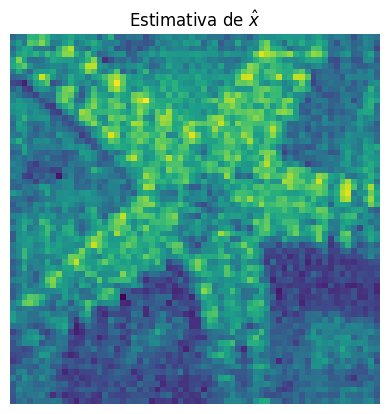

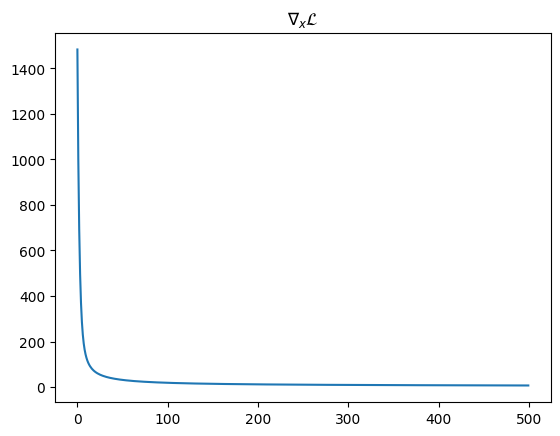

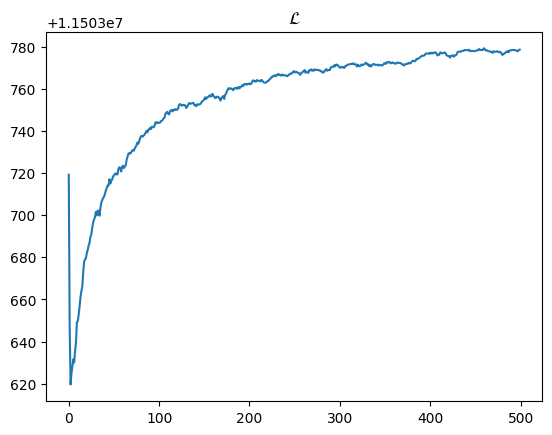


K-step 1 / 20:
500/500

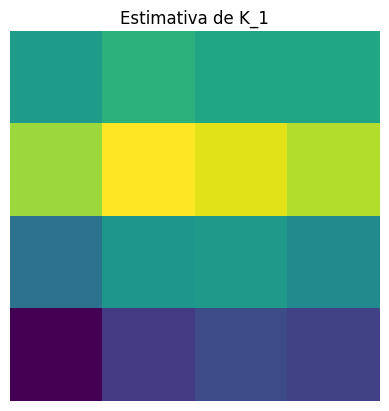

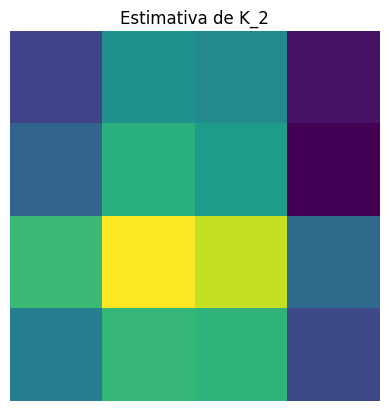


X-step 2 / 20:
500/500

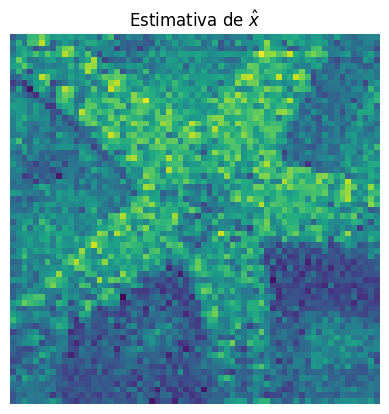

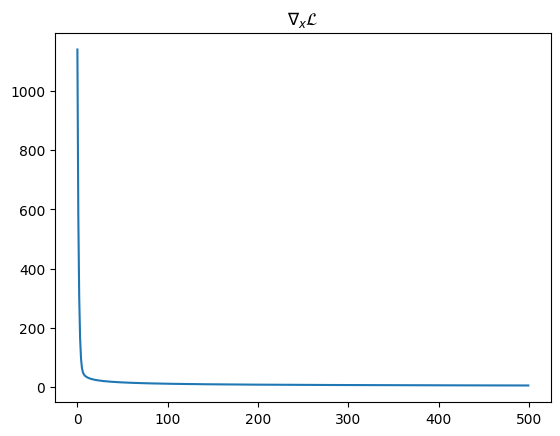

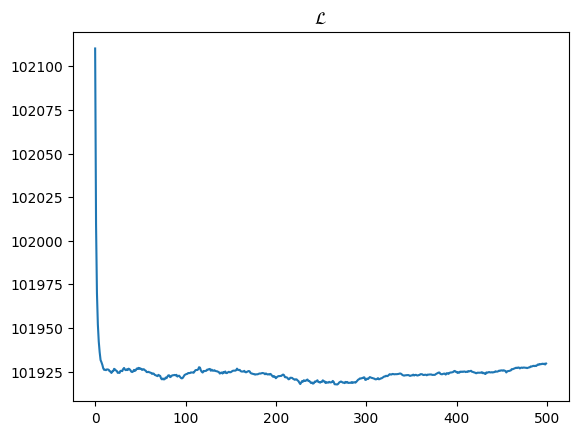


K-step 2 / 20:
500/500

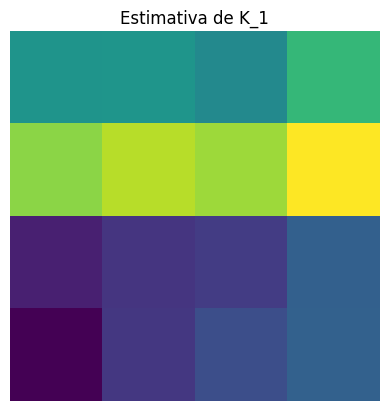

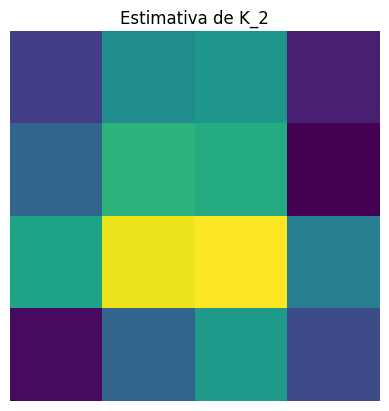


X-step 3 / 20:
500/500

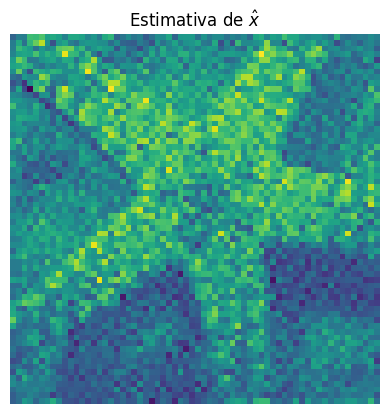

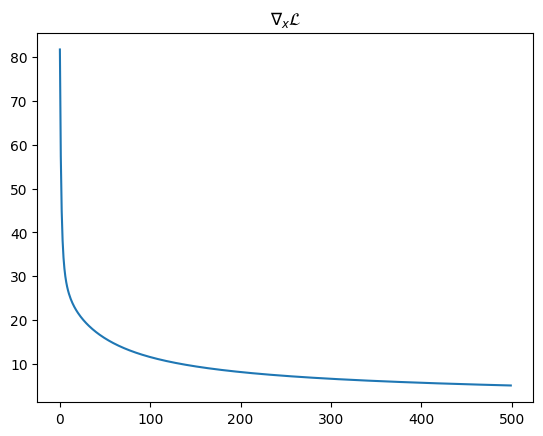

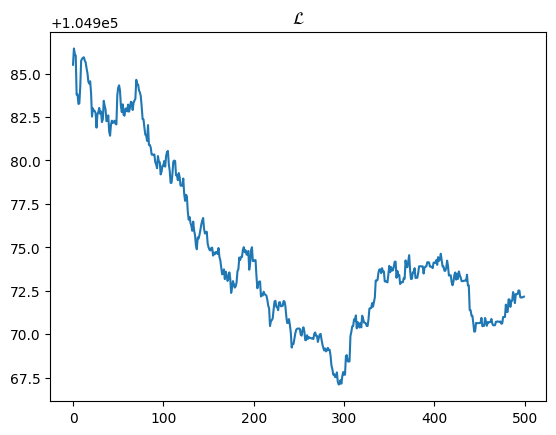


K-step 3 / 20:
500/500

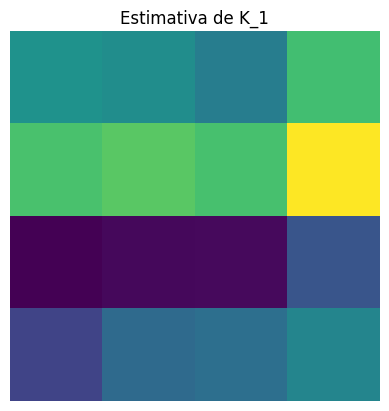

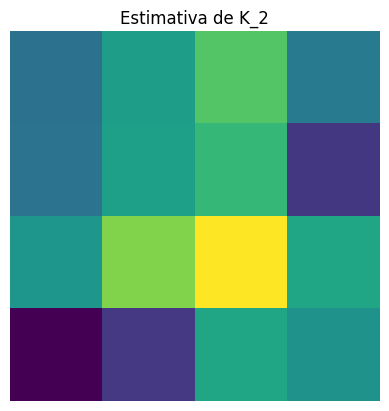


X-step 4 / 20:
500/500

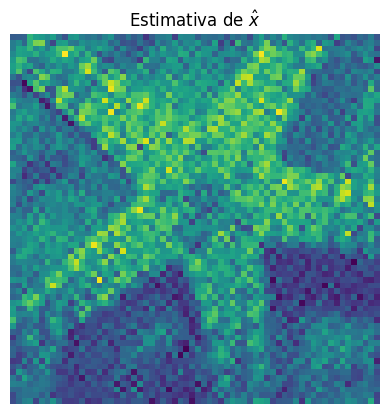

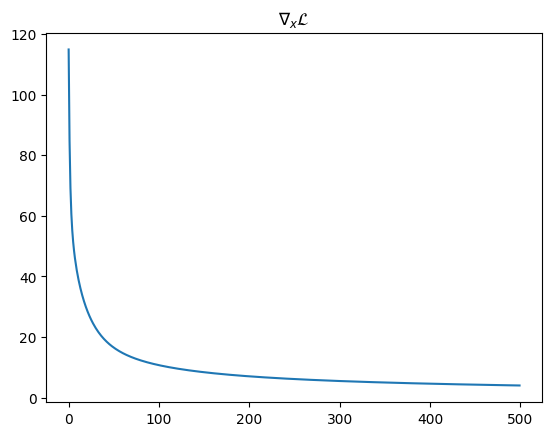

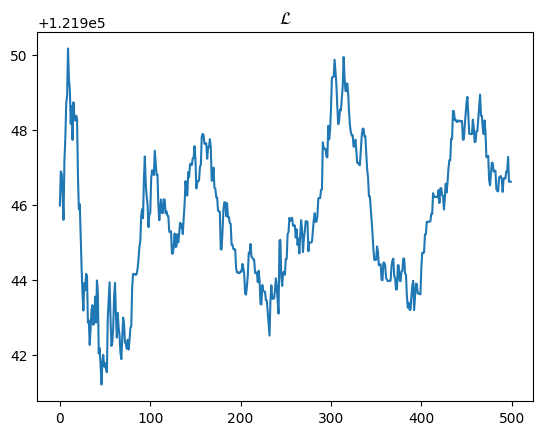


K-step 4 / 20:
500/500

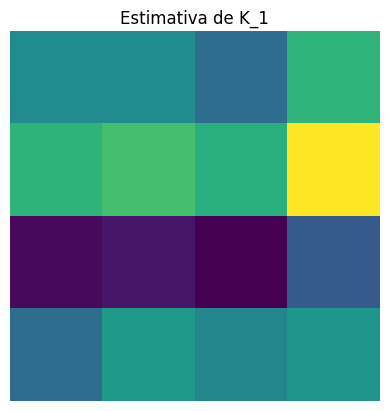

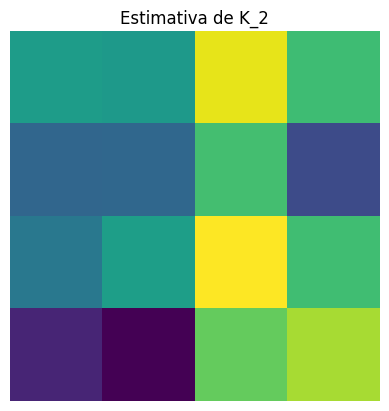


X-step 5 / 20:
500/500

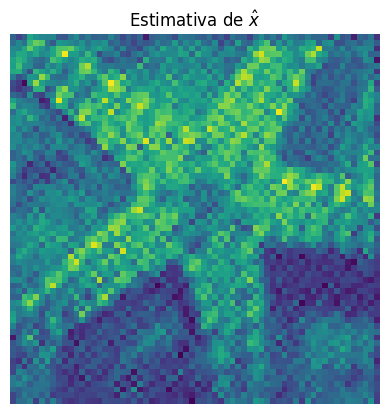

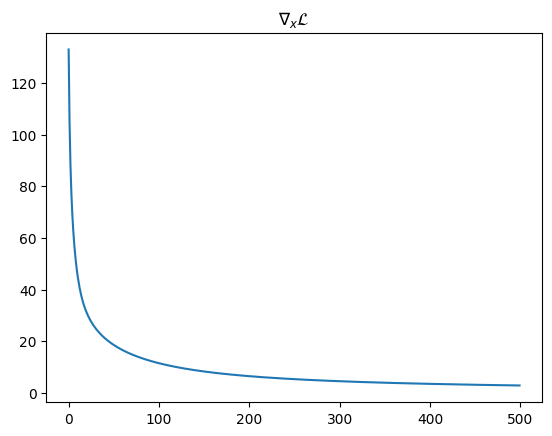

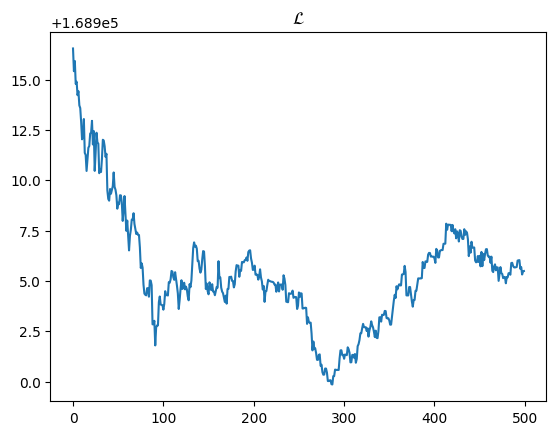


K-step 5 / 20:
500/500

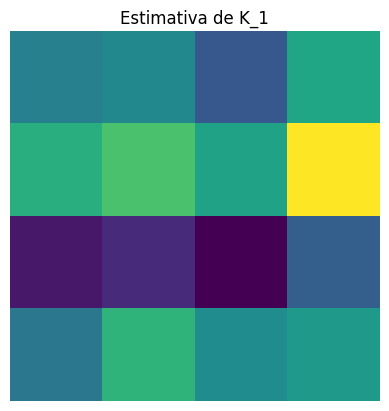

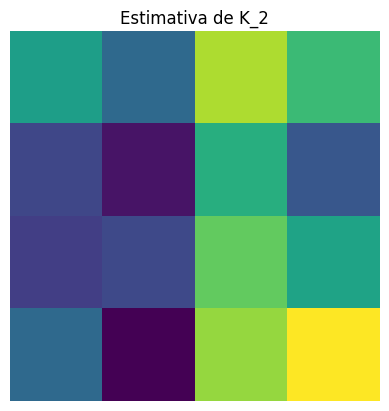


X-step 6 / 20:
500/500

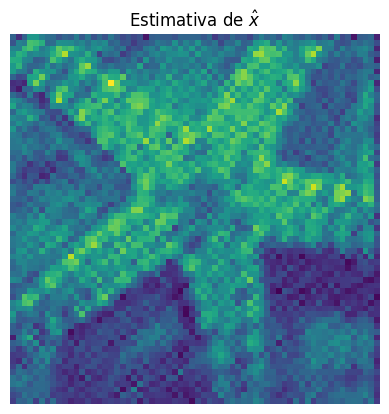

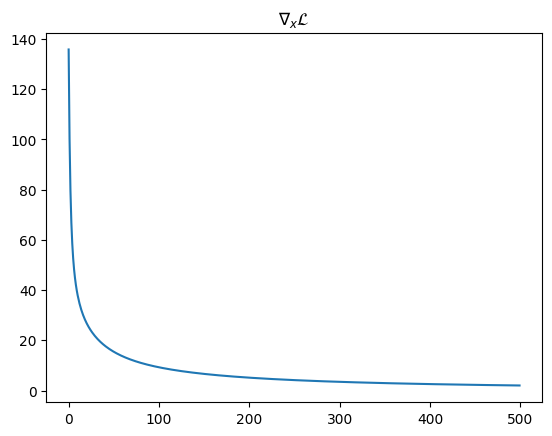

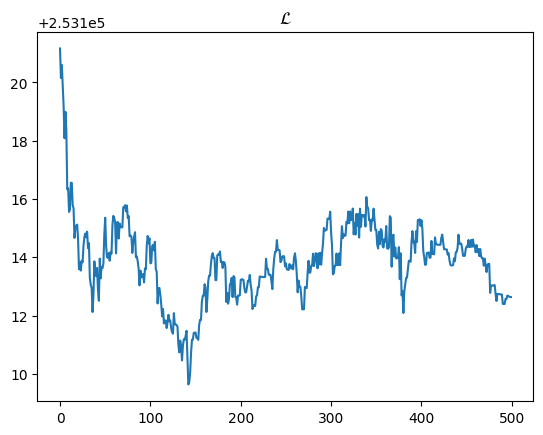


K-step 6 / 20:
500/500

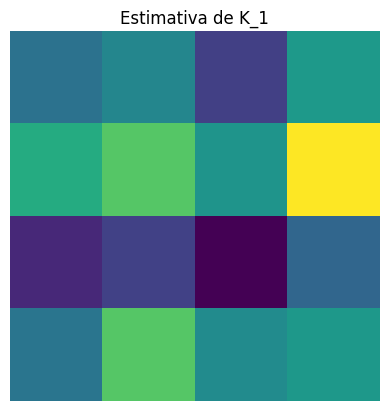

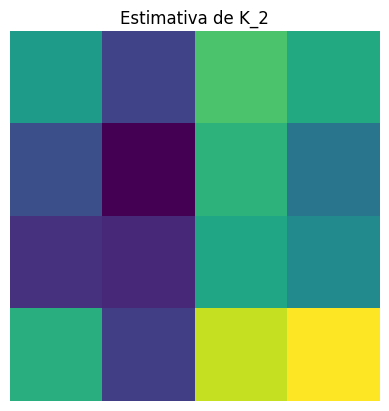


X-step 7 / 20:
500/500

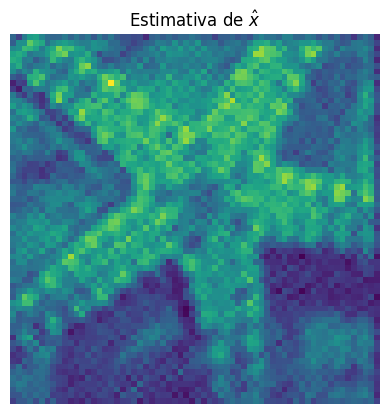

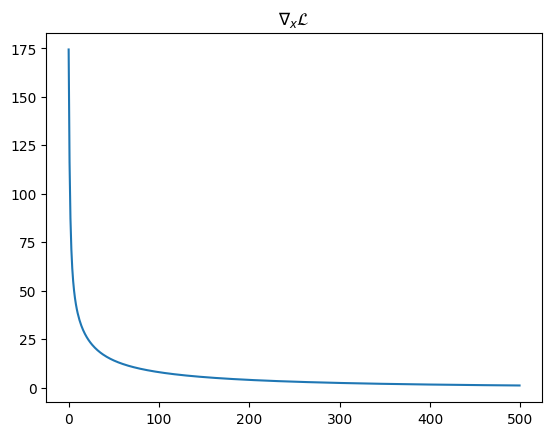

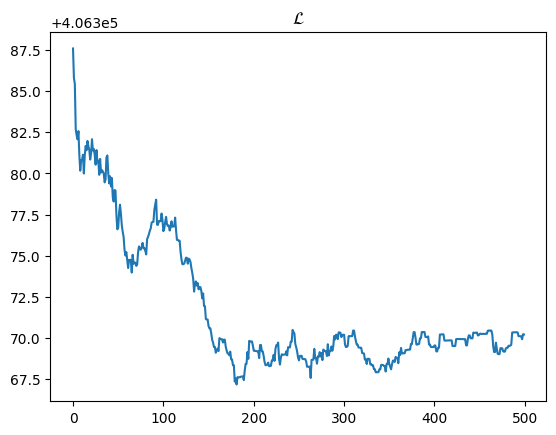


K-step 7 / 20:
500/500

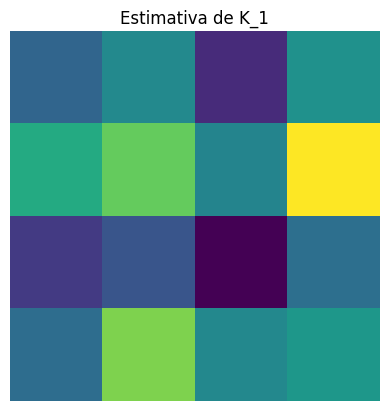

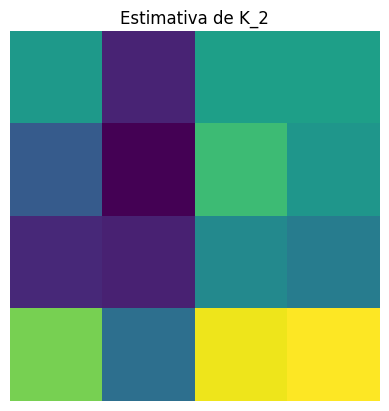


X-step 8 / 20:
500/500

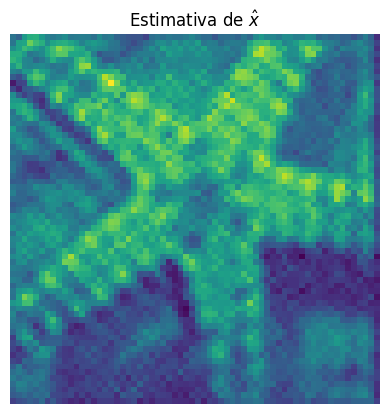

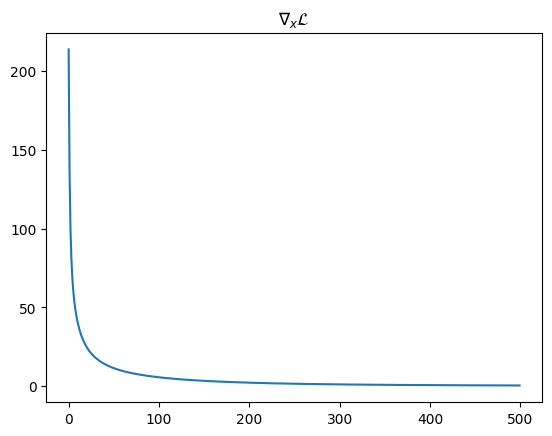

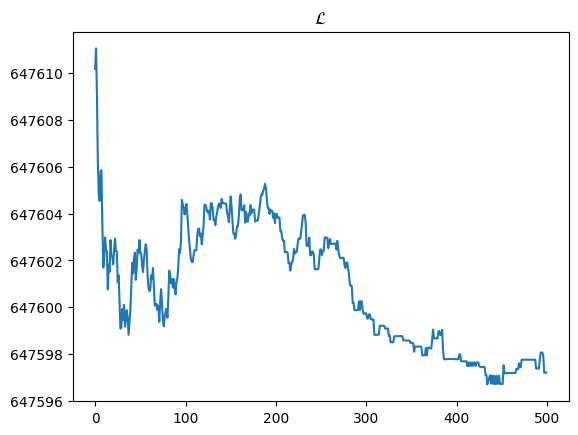


K-step 8 / 20:
500/500

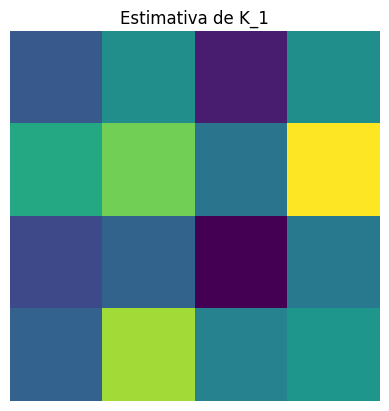

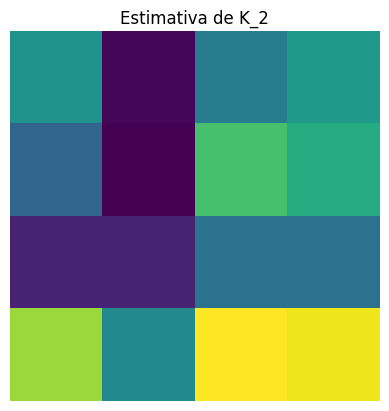


X-step 9 / 20:
500/500

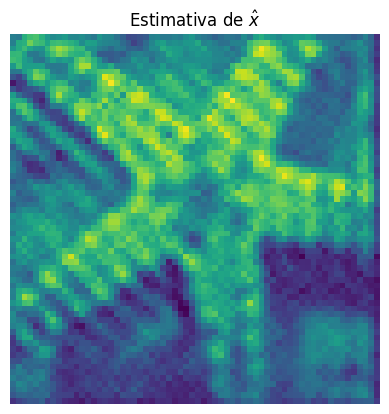

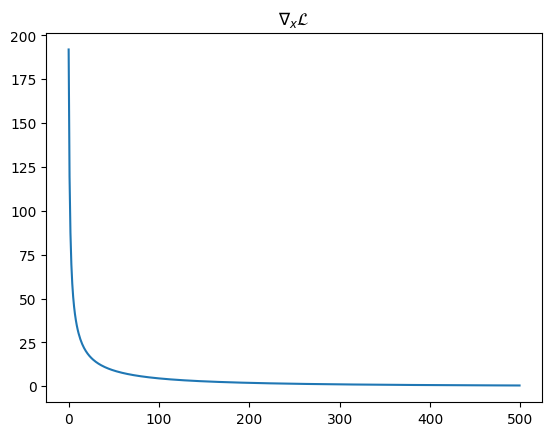

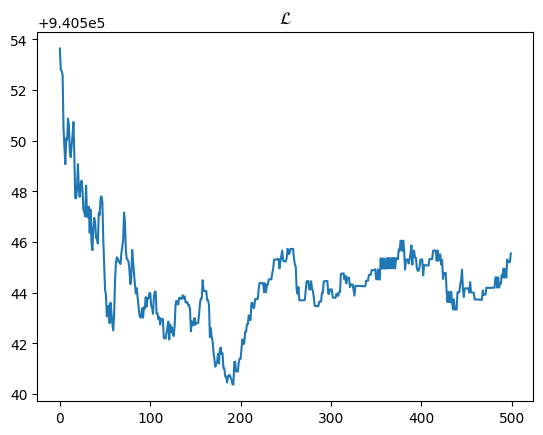


K-step 9 / 20:
500/500

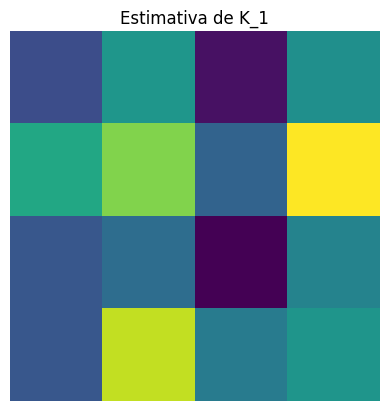

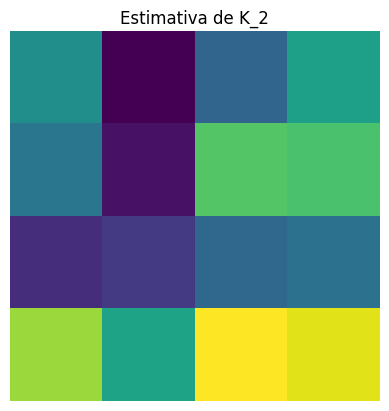


X-step 10 / 20:
88/500

/tmp/ipykernel_27423/2381254805.py:532: RuntimeWarning: invalid value encountered in cast
  n_term = lbda * (x - denoiser(x.astype(np.uint8)))


500/500

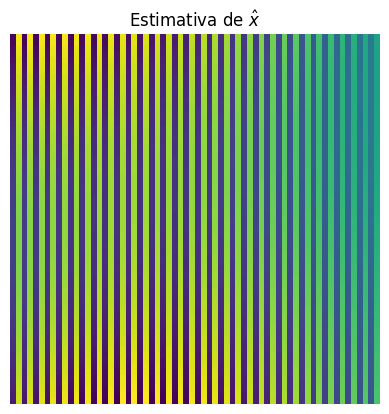

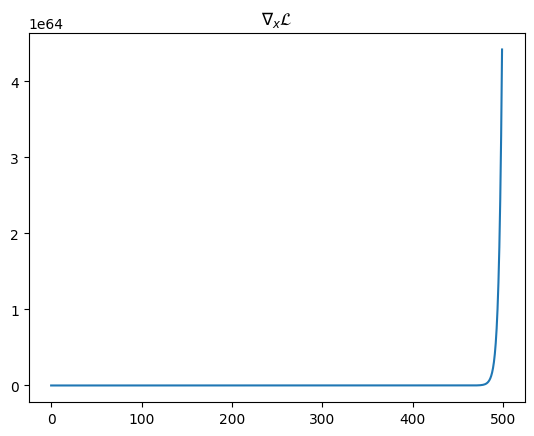

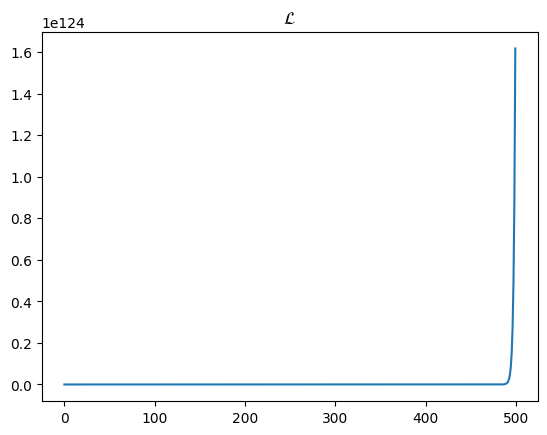


K-step 10 / 20:
500/500

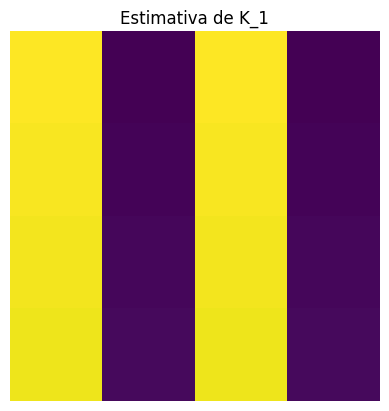

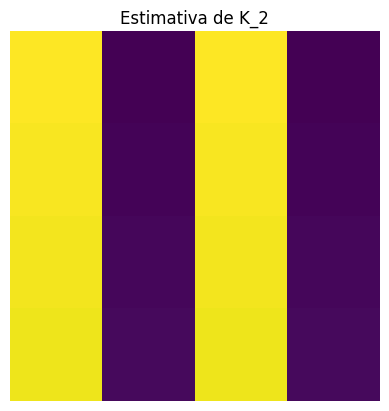


X-step 11 / 20:
16/500

/tmp/ipykernel_27423/2381254805.py:543: RuntimeWarning: overflow encountered in matmul
  lag_v[ii] += linalg.norm(reg_vals(x.T @ n_term))


36/500

/tmp/ipykernel_27423/2381254805.py:524: RuntimeWarning: overflow encountered in multiply
  np.conj(KK) * (KK * X - YY),


500/500

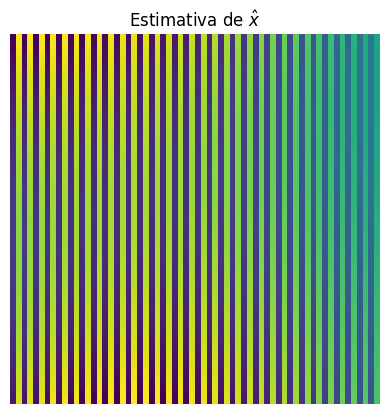

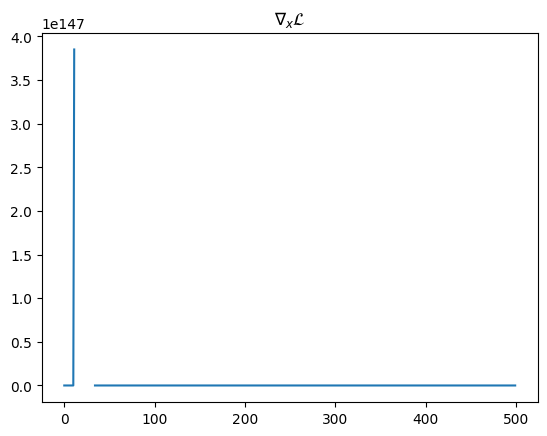

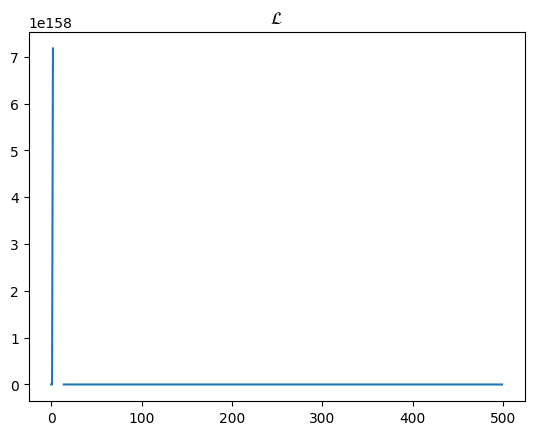


K-step 11 / 20:
1/500

/tmp/ipykernel_27423/2381254805.py:150: RuntimeWarning: overflow encountered in multiply
  np.conj(KK) * err


ValueError: array must not contain infs or NaNs

In [19]:
# Passos de otimizaç~ao utilizando apenas as fçs de custo 'isoladas' no 
# cen'ario multiobjetivo

# Determina o num interno de iteraç~oes por passo
int_iter = 20

# Declaraç~ao de estimativa de X
Y[:, :, 0]     = fft.fft2(blured_im[:, :, 0])
Y[:, :, 1]     = fft.fft2(blured_im[:, :, 1])
X_hat          = fft.fft2(np.mean(blured_im[:, :, :], axis=2))
K_hat          = np.zeros_like(Y)
tmp1           = gen_gaussian_kernel(4, 2, 0)[:size_k, :size_k]
tmp2           = np.ones((size_k, size_k)) - tmp1
K_hat[:, :, 0] = fft.fft2(tmp1, (K_hat.shape[0], K_hat.shape[1]))
K_hat[:, :, 1] = fft.fft2(tmp2 / np.sum(tmp2.sum()), (K_hat.shape[0], K_hat.shape[1]))

# Calcula TF's dos kerneis leg'itimos
print(ker.shape)
print(blured_im.shape)
KK          = np.zeros_like(K_hat, dtype=complex)
KK[:, :, 0] = fft.fft2(ker[:, :, 0])
KK[:, :, 1] = fft.fft2(ker[:, :, 1]) 

# Busca de lbda sobre o espaço com mu = 1.
llbda = [1e-5] #[1e-5]
cost  = np.zeros_like(llbda)

# Itera pelo espaço de lbda's
for ii, lbda in enumerate(llbda):
    # Primeiramente para verificar a convergencia sobre o param lbda --> UTILIZO OS KERNEIS LEG'ITIMOS
    x_hat, k_hat, _ = deconv_noise( #X_hat, n_term = fixed_point_x( #
        X_hat,
        K_hat,                      # KK, #
        Y,
        lbda,
        0.5, #1e-3,
        int_iter,                   # Param opcional (tirar qnd fixed point
        500,
        sk=size_k,
        p_flag=True
    )
    
    # Adquire reconstruça~o da Figura no dom. dos pixels
    X_hat     = fft.fft2(x_hat)
    K_hat     = fft.fft2(k_hat)
    
    # Computa Lagrangeano da iteraç~ao
    #cost[ii]  = reg_vals(cost_fun(
    #    KK, 
    #    X_hat, 
    #    lbda1=lbda
    #))
    #cost[ii] += linalg.norm(reg_vals(x_hat.T @ n_term))

#plt.plot(llbda, cost, label=r'$\mathcal{L}(\lambda)$')
#plt.xlabel(r'$\lambda$')
#plt.ylabel(r'$\mathcal{L}$')
#plt.legend()
#plt.show()

plt.imshow(x_hat[:s_fx, :s_fy], cmap='gray')
plt.show()
plt.imshow(blured_im[:s_fx, :s_fy, 0], cmap='gray')
plt.show()
              
# Primeiramente para verificar a convergencia sobre o param lbda --> UTILIZO OS KERNEIS LEG'ITIMOS
#x_hat, k_hat, cost2 = deconv_noise(
#    X_hat,
#    K_hat,
#    Y,
#    0.0,
#    1.0,
#    1_000,
#    int_iter,
#    sk=size_k,
#    p_flag=True
#)
#
#print(np.min(cost2))

# Teste com dados reais

Teste de deconvolução multicanal usando os dados reais. Obtidos em http://zoi.utia.cas.cz/deconvolution.html no arquivo data_set1

In [ ]:
# Lê imagens borradas para teste
inp_1 = cv2.imread('data_set1/input1.png', cv2.IMREAD_GRAYSCALE)
inp_2 = cv2.imread('data_set1/input2.png', cv2.IMREAD_GRAYSCALE)

# redimensionameto para tamanho do kernel
size_k = 54

# Redimensiona elas para terem formato quadrado
size  = np.min(inp_1.shape)
inp_1 = inp_1[:size, :size]
inp_2 = inp_2[:size, :size]

# Plotagem das imagens lidas
plt.imshow(inp_1)
plt.show()
plt.imshow(inp_2)
plt.show()

# Constroi vetor de entradas
y          = np.zeros((size, size, 2))
y[:, :, 0] = inp_1
y[:, :, 1] = inp_2

In [ ]:
# Inicia processamento com deconvolução não ruidosa
x_hat, _, _, _ = mult_decon_noiseless(y, 2, sk=size_k, iter_max=1)    

plt.imshow(x_hat)

In [ ]:
# Calcula TF de ponto inicial dos kernels (guassianas)
K_hat = np.zeros_like(y, dtype=complex)
for ii in range(2):
    K_hat[:, :, ii] = fft.fft2(
        gen_gaussian_kernel(size_k, 5),
        (size, size)
    )

# Encontra TF's de imagens borradas e estimativa
Y     = np.zeros_like(K_hat)
X_hat = fft.fft2(np.mean(y, axis=2))
for ii in range(n):
    Y[:, :, ii]   = fft.fft2(y[:, :, ii])

# Executa o teste de deconvolução ruidosa 
x_hat, k_hat, _ = deconv_noise(
    X_hat, 
    K_hat, 
    Y, 
    1e-3, 
    1e-7, 
    10, 
    500,
    sk=size_k,
    p_flag=True
)
    
plt.imshow(x_hat)
plt.show()
plt.imshow(k_hat[:, :, 0])
plt.show()
plt.imshow(k_hat[:, :, 1])
plt.show()

# Testes propostos pela Banca de qualificação

Porção dedicada ao debugging do sistema desenvolvido. Dessa forma, foi sugerido pela banca dois testes

1. **Verificação da convergência**: Se inicializado com a solução, o algoritmo deve permanecer na solução
1. **Comparação numérica**: Se comparado com uma aproximação numérica, o gradiente deve convergir para 

In [ ]:
## Teste da inicialização no ponto correto

s_fx, s_fy = im.shape
im_orig    = np.zeros_like(blured_im, dtype=complex)
for ii in range(blured_im.shape[2]):
    # Acrescenta em cada canal a imagem original
    im_orig[:, :, ii] = im

# Calcula as TFS dos kernels originais
K_hat = np.zeros_like(im_orig)
Y     = np.zeros_like(im_orig)
for ii in range(n):
    K_hat[:, :, ii] = fft.fft2(ker[:, :, ii], (s_fx, s_fy))
    Y[:, :, ii]     = fft.fft2(blured_im[:, :, ii], (s_fx, s_fy))
    
# Teste para modelagem não ruidosa
x_hat, _, _, lag = mult_decon_noiseless(blured_im, n, K_hat=K_hat, sk=size_k, iter_max=1, p_flag=True)  # Indicação de erro do grad!

In [ ]:
# Inicializa estimativa da imagem a partir de ponto original
X_hat = fft.fft2(im, (s_fx, s_fy))

# Teste para modelagem ruidosa
x_hat, k_hat, _ = deconv_noise(
    X_hat, 
    K_hat, 
    Y, 
    1e-1, 
    1, 
    10, 
    500,
    sk=size_k,
    p_flag=False
)
    
plt.imshow(x_hat)
plt.show()
plt.imshow(k_hat[:size_k, :size_k, 0])
plt.show()
plt.imshow(k_hat[:size_k, :size_k, 1])
plt.show()

In [ ]:
## Teste de aproximação numérica do gradiente:

#  Baseado na comparação da diferença central
#  (estimador numérico da derivada) a partir
#  da comparação da diferença "direta" e "reversa"
#  em torno de um ponto aleatório.

#  Caso dê xabú --> testar gradiente termo à termo

# Seta dimensionalidade para novos testes
shape_test = (10, 10)
s_tx, s_ty = shape_test

# Vetor Contendo razão de cada componente dos gradientes (numérico deve ser proporcional ao calculado)
factor = np.zeros((s_tx * s_ty * n))

# Traz consigo ponto central da imagem
IM  = fft.fft2(np.random.rand(s_tx, s_ty))

# Traz consigo intervalo eps
eps = 1e-5

# Índice externo
idx = 0

# Ciclo de testes
# Gera os pontos para avaliação do gradiente
ker_point = np.random.rand(s_tx, s_ty, n)
IMG_point = fft.fft2(np.random.rand(s_tx, s_ty, n))
KER_point = fft.fft2(ker_point)

# Gera gradiente calculado por função
Jac_calc = cost_fun_jac(IMG_point, KER_point, X=IM)
Jac_num  = np.zeros_like(Jac_calc)

# VERIFICAR FORMA EFICIENTE DE COMPUTAR ISSO DAQUI!!
for ii in range(s_tx):
    for jj in range(s_ty):
        for kk in range(n):
            # Cria matriz de perturbação
            pert             = np.zeros((s_tx, s_ty, n))
            pert[ii, jj, kk] = 1
            Pert             = eps * fft.fft2(pert)

            # Calcula as diferenças frontais e traseiras a partir de Pert
            F_dif = cost_fun(IMG_point, KER_point + Pert, X=IM)
            B_dif = cost_fun(IMG_point, KER_point - Pert, X=IM)

            # Estima gradiente numérico a partir da diferença numérica
            Jac_num[ii, jj, kk] = (F_dif - B_dif) / (2 * eps)

            # Calcula termo de erro
            factor[idx] = Jac_calc[ii, jj, kk] / Jac_num[ii, jj, kk]
            
            # Incrementa idx total
            idx += 1

# Cálculo da correlação (produto interno) entre os gradientes.
# --> Para verificar o alinhamento dos vetores
calc_v = Jac_calc.ravel() / linalg.norm(Jac_calc)
num_v  = Jac_num.ravel()  / linalg.norm(Jac_num)

# Imprime
corr_coef  = np.abs(np.dot(calc_v, num_v))
corr_coef *= 100

# Impressão da variação sobre a medida fator
print()
print('                            RESULTADOS                                      ')
print('------------------------------------------------------------------')
print(f'Média do fator: {np.round(np.mean(factor), 3)}, Desvio padrão: {np.round(np.std(factor), 3)}')
print(f'Coeficiente de correlação entre gradientes: {np.round(corr_coef, 2)}%')
print('------------------------------------------------------------------')
print()

# Impressão de gráfico de erro após o fim da simulação
plt.plot(factor)#[50:100])
plt.xlabel('Iteração')
plt.ylabel('Razão')
plt.title(r'$\nabla\mathcal{L} \ / \ \nabla\hat{\mathcal{L}}$')
plt.show()

## Avaliação das PSNR's de cada imagem

In [ ]:
## Importação das imagens sem ruído

# Kerneis originais
k1_ori = cv2.imread('figs_psnr/k1_ori.png', cv2.IMREAD_GRAYSCALE)
k2_ori = cv2.imread('figs_psnr/k2_ori.png', cv2.IMREAD_GRAYSCALE)

# Kerneis recuperados
k1_est_fix   = cv2.imread('figs_psnr/k1_est_fix.png', cv2.IMREAD_GRAYSCALE)
k1_est_bb    = cv2.imread('figs_psnr/k1_est_bb.png', cv2.IMREAD_GRAYSCALE)
k1_est_glob  = cv2.imread('figs_psnr/k1_est_glob.png', cv2.IMREAD_GRAYSCALE)
k1_est_secau = cv2.imread('figs_psnr/k1_est_secau.png', cv2.IMREAD_GRAYSCALE)
k2_est_fix   = cv2.imread('figs_psnr/k2_est_fix.png', cv2.IMREAD_GRAYSCALE)
k2_est_bb    = cv2.imread('figs_psnr/k2_est_bb.png', cv2.IMREAD_GRAYSCALE)
k2_est_glob  = cv2.imread('figs_psnr/k2_est_glob.png', cv2.IMREAD_GRAYSCALE)
k2_est_secau = cv2.imread('figs_psnr/k2_est_secau.png', cv2.IMREAD_GRAYSCALE)

k2_ori = k2_ori[:168, :168]

# Estimativa das PSNR's das recuperações sem ruído
print('Estimativas de k1: ')
print('BB: ', calc_psnr(k1_ori, k1_est_bb), ' dB')
print('FI: ', calc_psnr(k1_ori, k1_est_fix), ' dB')
print('GL: ', calc_psnr(k1_ori, k1_est_glob), ' dB')
print('SA: ', calc_psnr(k1_ori, k1_est_secau), ' dB')
print()
print('Estimativas de k2: ')
print('BB: ', calc_psnr(k2_ori, k2_est_bb[:168, :168]), ' dB')
print('FI: ', calc_psnr(k2_ori, k2_est_fix), ' dB')
print('GL: ', calc_psnr(k2_ori, k2_est_glob[:168, :168]), ' dB')
print('SA: ', calc_psnr(k2_ori[:167, :167], k2_est_secau[:167, :167]), ' dB')
print()

## Importação das imagens ruidosas

k1_rand = cv2.imread('figs_psnr/k1_ori_rand.png', cv2.IMREAD_GRAYSCALE)
k2_rand = cv2.imread('figs_psnr/k2_ori_rand.png', cv2.IMREAD_GRAYSCALE)
k1_simp = cv2.imread('figs_psnr/k1_ori_simp.png', cv2.IMREAD_GRAYSCALE)
k2_simp = cv2.imread('figs_psnr/k2_ori_simp.png', cv2.IMREAD_GRAYSCALE)
img_ori = cv2.imread('figs_psnr/img_orig_rand_noise.png', cv2.IMREAD_GRAYSCALE)
k1_rand_est = cv2.imread('figs_psnr/k1_est_rand.png', cv2.IMREAD_GRAYSCALE)
k2_rand_est = cv2.imread('figs_psnr/k2_est_rand.png', cv2.IMREAD_GRAYSCALE)
k1_simp_est = cv2.imread('figs_psnr/k1_est_simp.png', cv2.IMREAD_GRAYSCALE)
k2_simp_est = cv2.imread('figs_psnr/k2_est_simp.png', cv2.IMREAD_GRAYSCALE)
recup_rand  = cv2.imread('figs_psnr/recup_rand_noise.png', cv2.IMREAD_GRAYSCALE)
recup_simp  = cv2.imread('figs_psnr/recup_simp_noise.png', cv2.IMREAD_GRAYSCALE)

print('Estimativas Ruidosas')
print('K1 simp: ', calc_psnr(k1_simp, k1_simp_est), ' dB')
print('K2 simp: ', calc_psnr(k2_simp, k2_simp_est), ' dB')
print('K1 rand: ', calc_psnr(k1_rand, k1_rand_est[:180, :180]), ' dB')
print('K2 rand: ', calc_psnr(k2_rand, k2_rand_est), ' dB')
print('Recup simp: ', calc_psnr(img_ori, recup_simp), ' dB')
print('Recup rand: ', calc_psnr(img_ori, recup_rand), ' dB')